In [1]:
from utils.shuqing_all import *

In [2]:
!pip3 install lightgbm --quiet
!pip3 install hyperopt --quiet
!pip3 install optuna --quiet

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
%matplotlib inline 
plt.style.use('fivethirtyeight')
five_thrity_eight=[
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",    
]
sns.set_palette(five_thrity_eight)
from datetime import datetime
import pydata_google_auth
from plotly import graph_objects as go
import datetime as dt
import lifelines
from lifelines import KaplanMeierFitter
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
!pip3 install pdpbox --quiet
from pdpbox import pdp
from sklearn.inspection import permutation_importance
import shap
import datetime 
import pickle
import joblib
import os
import lightgbm as lgb
from lightgbm import LGBMClassifier
import lifelines
from lifelines import KaplanMeierFitter
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve,f1_score,auc,plot_confusion_matrix,confusion_matrix,plot_roc_curve

In [91]:
sql="""
SELECT  partner_position_id
,started_at
,b.*
FROM `uw-data-models-prod.partner_dataform_models_position.position` a

LEFT JOIN  `uw-data-models-prod.partner_dataform_models_position.onboarding_milestones`  b 
USING(partner_position_id)
WHERE date_diff(CURRENT_DATE(), CAST(started_at AS DATE ), DAY)<=90

# WHERE started_at  >'2021-04-19'
"""

power_up_sql="""
SELECT  partner_position_id
,started_at
,b.*
FROM `uw-data-models-prod.partner_dataform_models_position.position` a

LEFT JOIN  `uw-data-models-prod.partner_dataform_models_position.onboarding_milestones`  b 
USING(partner_position_id)


WHERE started_at  >'2021-04-19'
"""


app_sql="""
WITH users AS (
    SELECT DISTINCT(partner_position_id) AS partner_position_id
    FROM `uw-data-models-prod.partner_dataform_models_partner_app_analytics.sessions`
    WHERE is_staff IS FALSE
)
SELECT users.*
FROM users
LEFT JOIN `uw-data-models-prod.partner_dataform_models_position.position` pos
ON users.partner_position_id = pos.partner_position_id
WHERE pos.started_at >= '2021-04-19'

"""

is_customer ="""
SELECT 
partner_position_id
,customer_partner_position_id

 FROM 
(SELECT 
partner_position_id
,customer_partner_position_id
,ROW_NUMBER() OVER (PARTITION BY partner_position_id ORDER BY started_timestamp DESC) AS num

FROM `uw-partner-prod.consolidated.customer`
)
WHERE num = 1 

"""
customer_gained_date="""

SELECT  
customer_account_number,
partner_position_id,
gain_timestamp,
current_live_services
FROM `uw-partner-prod.consolidated.customer`

"""
prospects = """
WITH final AS 

(SELECT  
 *


FROM `uw-data-models-prod.partner_dataform_models_position.planner_first_prospects_dates_added` b
LEFT JOIN 
(SELECT partner_position_id
,started_at
FROM `uw-data-models-prod.partner_dataform_models_position.position`) AS a
ON b.partner_position_id = a.partner_position_id
)

SELECT 
*
,DATE_DIFF(prospect_1_added_date,CAST(started_at AS date) ,DAY) AS days_since_joining_prospect_1
,DATE_DIFF(prospect_2_added_date,CAST(started_at AS date) ,DAY) AS days_since_joining_prospect_2
,DATE_DIFF(prospect_3_added_date,CAST(started_at AS date) ,DAY) AS days_since_joining_prospect_3
,DATE_DIFF(prospect_4_added_date,CAST(started_at AS date) ,DAY) AS days_since_joining_prospect_4
,DATE_DIFF(prospect_5_added_date,CAST(started_at AS date) ,DAY) AS days_since_joining_prospect_5
, DATE_DIFF(prospect_6_added_date,CAST(started_at AS date) ,DAY) AS days_since_joining_prospect_6
,DATE_DIFF(prospect_7_added_date,CAST(started_at AS date) ,DAY) AS days_since_joining_prospect_7
,DATE_DIFF(prospect_8_added_date,CAST(started_at AS date) ,DAY) AS days_since_joining_prospect_8
,DATE_DIFF(prospect_9_added_date,CAST(started_at AS date) ,DAY) AS days_since_joining_prospect_9
,DATE_DIFF(prospect_10_added_date,CAST(started_at AS date) ,DAY) AS days_since_joining_prospect_10
FROM final
WHERE prospect_1_added_date >'2018-01-01'


"""

In [92]:
app_profilling_sql="""
  SELECT * 
 FROM 
 `uw-data-models-prod.partner_dataform_models_feature_catalogue.mobile_app_sessions` a
LEFT JOIN 
 (SELECT * 
 FROM 
 `uw-data-models-prod.partner_dataform_models_feature_catalogue.mobile_app_profiling`) b 
 ON a.partner_position_id = b.partner_position_id

"""

q = """SELECT 
started_date,
EXTRACT(YEAR FROM started_date) as year_joined,
CAST(ended_at as DATE) as ended_date, 
last_customer_gathered_date IS NOT NULL as has_gathered_customer,
DATE_DIFF(
       COALESCE(last_customer_gathered_date, started_date), 
       started_date, DAY) days_of_activity_tenure,
# DATE_DIFF(snapshot_date, COALESCE(last_customer_gathered_date, started_date), DAY) > 3
# OR ended_at IS NOT NULL as observed_inactive,
DATE_DIFF(COALESCE(CAST(ended_at as DATE), snapshot_date), started_date,DAY) as days_of_tenure,
b.is_live = 0 as observed_churned
FROM `uw-data-models-prod.partner_dataform_models_aggregated.partner_position_activity_daily` a
INNER JOIN `uw-data-models-prod.partner_dataform_models_aggregated.partner_position_daily` b USING(snapshot_date, partner_position_id)
WHERE snapshot_date = '2021-06-04'
AND started_date >= '2015-01-01'
"""

In [93]:
appointment= """
SELECT 
partner_position_id
,appointment_created_at
FROM (

SELECT 

partner_position_id
,CAST(appointment_created_at AS DATE) AS appointment_created_at

,ROW_NUMBER() OVER (PARTITION BY partner_position_id ORDER BY appointment_created_at ASC) AS num

FROM `uw-partner-prod.consolidated.my_planner_appointments` ) 
WHERE num =1


"""

In [94]:
customer_gather ="""

SELECT * FROM `uw-data-models-prod.partner_dataform_models_position.first_customers_gathered_dates_excluding_self`


"""

In [95]:

def check_parameters(parameters,values,fixed={},features=None):
    scores=[]
    f1=[]
    auc=[]
    for p in values:
        print(f'Fitting with {parameters}={p}')
        fts= X_train.columns if features is None else features
        kw = {parameters:p, **fixed}
        model=RandomForestClassifier(**kw)
        %time model.fit(X_train[fts],y_train)
        s=roc_auc_score(y_valid,model.predict_proba(X_valid)[:,1])
        rf_f1,rf_auc=auc_score(model,X_valid[fts],y_valid)
        
        print('ROC AUC Score',s)
        print('F1',rf_f1)
        print('Auc',rf_auc)
        print('')
        scores.append(rf_auc)
        f1.append(rf_f1)
        auc.append(rf_auc)
    plt.title(parameters)
    plt.plot(values,scores)


def pass_df(q):
    if q==power_up_sql:
        df=download_data(project_id='uw-data-warehouse-prod',query=power_up_sql)
    else:
        df=download_data(project_id='uw-data-warehouse-prod',query=sql)
    return df

In [96]:
df=pass_df(power_up_sql)

Downloading:   0%|          | 0/2094 [00:00<?, ?rows/s]

In [49]:
# def moving_message(*args):
#     user_name,message=args
#     print(f'{message} from {user_name}')
# returning_values=('user_name','message')
# moving_message(*returning_values)

message from user_name


In [97]:
app=download_data(project_id='uw-data-warehouse-prod',query=app_sql)

Downloading:   0%|          | 0/1120 [00:00<?, ?rows/s]

In [98]:
app_profilling=download_data(project_id='uw-data-warehouse-prod',query=app_profilling_sql)

Downloading:   0%|          | 0/2725 [00:00<?, ?rows/s]

In [99]:
is_customer_df=download_data(project_id='uw-data-warehouse-prod',query =is_customer)

Downloading:   0%|          | 0/105231 [00:00<?, ?rows/s]

In [100]:
prospects_df=download_data(project_id='uw-data-warehouse-prod',query =prospects)

Downloading:   0%|          | 0/16361 [00:00<?, ?rows/s]

In [101]:
appointment_df=download_data(project_id='uw-data-warehouse-prod',query =appointment)

Downloading:   0%|          | 0/6030 [00:00<?, ?rows/s]

In [102]:
customer_df=download_data(project_id='uw-data-warehouse-prod',query=customer_gather)

Downloading:   0%|          | 0/92927 [00:00<?, ?rows/s]

In [103]:
df.drop(['partner_position_id_1'],axis=1,inplace=True)
df['started_at']=df.started_at.dt.date
df['started_at']=pd.to_datetime(df.started_at)
date_col=df.select_dtypes(include=['datetime']).columns.tolist()

In [104]:
for c in date_col:
    df[c]=pd.to_datetime(df[c])

In [105]:
tenure_list=df.columns[2:10].tolist()

In [106]:
tenure_list

['sixth_prospect_added_date',
 'first_prospect_added_date',
 'verification_date',
 'getting_started_online_completed_date',
 'first_application_date',
 'first_customer_gathered_excluding_self_date',
 'second_customer_gathered_excluding_self_date',
 'first_gathered_six_personal_customers_date']

In [107]:
tenure_list.append('customer_2_gathered_date')
tenure_list.append('customer_3_gathered_date')
tenure_list.append('customer_4_gathered_date')
tenure_list.append('customer_5_gathered_date')
tenure_list.append('customer_7_gathered_date')
tenure_list.append('customer_8_gathered_date')
tenure_list.append('customer_9_gathered_date')
tenure_list.append('customer_10_gathered_date')

In [108]:
df.shape

(2094, 12)

In [109]:
df=df.merge(customer_df,left_on=['partner_position_id'],right_on=['partner_position_id'],how='left')
df=tenure_compute(df,tenure_list,'started_at')
df.loc[:,'app_users']=np.where(df.partner_position_id.isin(app.partner_position_id.values),1,0)
df=tenure_compute(df,['getting_started_online_completed_date'],'verification_date')
df['has_added_six_prospect']=np.where(~df.sixth_prospect_added_date.isnull(),1,0)
df=convert_tenure_dates(df)
df['tenure_customer_2_gathered_from_started_at']=df.tenure_customer_2_gathered_from_started_at.apply(lambda x: x if x<=45 else np.NaN)

In [110]:
timestamp_cols=[col for col in app_profilling.columns if 'timestamp' in col]
convert_to_datetime(app_profilling,timestamp_cols)
app_profilling.drop('partner_position_id_1',axis=1,inplace=True)

In [111]:
df=df.merge(app_profilling,left_on=['partner_position_id'],right_on=['partner_position_id'],how='left')
df=df.merge(is_customer_df,left_on=['partner_position_id'],right_on=['partner_position_id'],how='left')

In [112]:
preprocess=Preprocessing(df)

In [113]:
preprocess.check_null()

,total,percent,dtype
became_pro_graduation_eligible_date,2088,0.997135,object
tenure_customer_10_gathered_from_started_at,2085,0.995702,datetime64[ns]
customer_10_gathered_date,2085,0.995702,datetime64[ns]
customer_9_gathered_date,2081,0.993792,datetime64[ns]
tenure_customer_9_gathered_from_started_at,2081,0.993792,datetime64[ns]
...,...,...,...
tenure_verification_from_started_at,824,0.393505,float64
has_added_six_prospect,0,0.000000,object
app_users,0,0.000000,object
started_at,0,0.000000,float64


In [114]:
days_cols=[c for c in prospects_df.columns if 'days' in c ]

for c in days_cols:
    prospects_df[c] = prospects_df[c].apply(lambda x: x if x <= 45 else np.NaN)

days_cols.append('partner_position_id')
df=df.merge(prospects_df[days_cols],left_on=['partner_position_id'],right_on=['partner_position_id'],how='left')

In [115]:
df.shape

(2094, 71)

In [116]:
is_customer_df['is_customer']=np.where(is_customer_df.customer_partner_position_id.isnull(),0,1)
is_customer_df.drop_duplicates(subset=['partner_position_id'],inplace=True)
df=df.merge(is_customer_df[['partner_position_id','is_customer']],left_on=['partner_position_id'],right_on=['partner_position_id'],how='left')

In [117]:
df=df.merge(appointment_df,left_on=['partner_position_id'],right_on=['partner_position_id'],how='left')

In [118]:
df=quality_control_date_diff_less_0(df,'tenure_getting_started_online_completed_from_verification_date')

tenure_first_customer_gathered_excluding_self_from_started_at


In [119]:
(df.partner_position_id.value_counts()>1).sum()

0

### Don't run AS OF 20-07-2021


In [35]:
df=tenure_compute(df,['customer_2_gathered_date'],'customer_1_gathered_date')
df['tenure_customer_2_gathered_from_customer_1_gathered_date']=df.tenure_customer_2_gathered_from_customer_1_gathered_date.dt.days

In [36]:
d45_cols=['tenure_first_customer_gathered_excluding_self_from_started_at',
 'tenure_customer_2_gathered_from_started_at','tenure_customer_3_gathered_from_started_at',
          'tenure_customer_4_gathered_from_started_at','tenure_customer_5_gathered_from_started_at',
          'tenure_first_gathered_six_personal_customers_from_started_at',
     'tenure_customer_7_gathered_from_started_at',
         'tenure_customer_8_gathered_from_started_at','tenure_customer_9_gathered_from_started_at',
          'tenure_customer_10_gathered_from_started_at']

In [37]:
d45_cols=['tenure_first_customer_gathered_excluding_self',
 'tenure_customer_2_gathered','tenure_customer_3_gathered',
          'tenure_customer_4_gathered','tenure_customer_5_gathered',
          'tenure_first_gathered_six_personal_customers',
     'tenure_customer_7_gathered',
         'tenure_customer_8_gathered','tenure_customer_9_gathered',
          'tenure_customer_10_gathered']

In [222]:
for c in d45_cols:
    df[c]=df[c].apply(lambda x: x if x <=45 else np.NaN)

In [223]:
cols=[]

In [224]:
for c in d45_cols:
    c=c.replace('tenure_','').replace('_from_started_at','')
    cols.append(c)

In [225]:
cols=cols[:6]

In [226]:
import plotly.express as px

In [227]:
from plotly import graph_objects as go

In [228]:
app_d=[df.loc[df.app_users==1].shape[0]]
non_app_d=[df.loc[df.app_users==0].shape[0]]

In [229]:
for c in d45_cols:
    d=df.loc[df.app_users==1,c].notnull().sum()
    app_d.append(d)
    n_d=df.loc[df.app_users!=1,c].notnull().sum()
    non_app_d.append(n_d)

In [230]:
all_d=[df.shape[0]]
for c in d45_cols:
    d=df[c].notnull().sum()
    all_d.append(d)

In [231]:
new_cols=['zero customer gathered','customer_1_gathered_excluding_self',
 'customer_2_gathered',
 'customer_3_gathered',
 'customer_4_gathered',
 'customer_5_gathered',
 'customer_6_gathered']

In [82]:
# df_app=pd.DataFrame(dict(number=app_d,stage=cols))
# df_app['app_user']='yes'
# df_non_app=pd.DataFrame(dict(number=non_app_d,stage=cols))
# df_non_app['app_user']='no'
# app=pd.concat([df_app,df_non_app],axis=0)

In [61]:
# px.funnel(app,x='number',y='stage',color='app_user')

In [232]:
fig=go.Figure()
fig.add_trace(go.Funnel(
    name='new partners',
     y=new_cols,
    x=all_d,
    textinfo='value+percent previous'))

In [234]:
fig=go.Figure()
fig.add_trace(go.Funnel(
    name='non app user',
    orientation='h',
    y=new_cols,
    x=non_app_d,
textinfo='value+percent previous'))
fig.add_trace(go.Funnel(
    name='app user',
     y=new_cols,
    x=app_d,
    textinfo='value+percent previous'))

In [189]:
for c in d45_cols:
    print(f'PowerUp App User {c}:',df.loc[df.app_users==1,c].notnull().sum(),df.loc[df.app_users==1,c].notnull().sum()/df.loc[df.app_users==1].shape[0])

PowerUp App User tenure_first_customer_gathered_excluding_self_from_started_at: 262 0.28602620087336245
PowerUp App User tenure_customer_2_gathered_from_started_at: 134 0.1462882096069869
PowerUp App User tenure_customer_3_gathered_from_started_at: 73 0.07969432314410481
PowerUp App User tenure_customer_4_gathered_from_started_at: 41 0.04475982532751092
PowerUp App User tenure_customer_5_gathered_from_started_at: 22 0.024017467248908297
PowerUp App User tenure_customer_7_gathered_from_started_at: 9 0.009825327510917031
PowerUp App User tenure_customer_8_gathered_from_started_at: 6 0.006550218340611353
PowerUp App User tenure_customer_9_gathered_from_started_at: 2 0.002183406113537118
PowerUp App User tenure_customer_10_gathered_from_started_at: 1 0.001091703056768559


In [190]:
for c in d45_cols:
    print(f'PowerUp Non App User {c}:',df.loc[df.app_users!=1,c].notnull().sum(),df.loc[df.app_users!=1,c].notnull().sum()/df.loc[df.app_users!=1].shape[0])

PowerUp Non App User tenure_first_customer_gathered_excluding_self_from_started_at: 113 0.13696969696969696
PowerUp Non App User tenure_customer_2_gathered_from_started_at: 50 0.06060606060606061
PowerUp Non App User tenure_customer_3_gathered_from_started_at: 24 0.02909090909090909
PowerUp Non App User tenure_customer_4_gathered_from_started_at: 14 0.01696969696969697
PowerUp Non App User tenure_customer_5_gathered_from_started_at: 10 0.012121212121212121
PowerUp Non App User tenure_customer_7_gathered_from_started_at: 4 0.0048484848484848485
PowerUp Non App User tenure_customer_8_gathered_from_started_at: 2 0.0024242424242424242
PowerUp Non App User tenure_customer_9_gathered_from_started_at: 2 0.0024242424242424242
PowerUp Non App User tenure_customer_10_gathered_from_started_at: 1 0.0012121212121212121


In [223]:
for c in d45_cols:
    print(f'PowerUp {c}:',df[c].notnull().sum(),df[c].notnull().sum()/df.shape[0])

PowerUp tenure_first_customer_gathered_excluding_self_from_started_at: 315 0.20682862770847013
PowerUp tenure_customer_2_gathered_from_started_at: 157 0.103086014445174
PowerUp tenure_customer_3_gathered_from_started_at: 78 0.05121470781352593
PowerUp tenure_customer_4_gathered_from_started_at: 44 0.028890347997373604
PowerUp tenure_customer_5_gathered_from_started_at: 23 0.015101772816808929
PowerUp tenure_customer_6_gathered_from_started_at: 15 0.00984898227183191
PowerUp tenure_customer_7_gathered_from_started_at: 9 0.005909389363099146
PowerUp tenure_customer_8_gathered_from_started_at: 7 0.004596191726854892
PowerUp tenure_customer_9_gathered_from_started_at: 4 0.0026263952724885093
PowerUp tenure_customer_10_gathered_from_started_at: 2 0.0013131976362442547


In [239]:
df.loc[df.tenure_first_customer_gathered_excluding_self_from_started_at.notnull(),'tenure_customer_2_gathered_from_customer_1_gathered_date'].mean(),df.loc[df.tenure_first_customer_gathered_excluding_self_from_started_at.notnull(),'tenure_customer_2_gathered_from_customer_1_gathered_date'].median()

(7.740963855421687, 4.0)

In [ ]:
print(f'within 45 days',df.customer_2_gathered_date.notnull().sum()/df.shape[0])
print(df.shape[0],df.customer_2_gathered_date.notnull().sum())

In [192]:
print(f'powerup',df.customer_2_gathered_date.notnull().sum()/df.shape[0])
print(df.shape[0],df.customer_2_gathered_date.notnull().sum())
print(df.first_customer_gathered_excluding_self_date.notnull().sum(),df.first_customer_gathered_excluding_self_date.notnull().sum()/df.shape[0])
print(f'3 customers',df.customer_3_gathered_date.notnull().sum(),df.customer_3_gathered_date.notnull().sum()/df.shape[0])

powerup 0.10899540380827315
1523 166
322 0.211424819435325
3 customers 82 0.05384110308601445


In [112]:
print(f'mean',df[['tenure_first_customer_gathered_excluding_self_from_started_at','tenure_customer_2_gathered_from_started_at']].mean())
print(f'median',df[['tenure_first_customer_gathered_excluding_self_from_started_at','tenure_customer_2_gathered_from_started_at']].median())


mean tenure_first_customer_gathered_excluding_self_from_started_at    12.512422
tenure_customer_2_gathered_from_started_at                       16.681529
dtype: float64
median tenure_first_customer_gathered_excluding_self_from_started_at     9.0
tenure_customer_2_gathered_from_started_at                       14.0
dtype: float64


# Prediction of Customer Acquisition - Gather Two Customer

In [120]:
# create new features
df.rename(columns=lambda x: x.replace('_from_started_at',''),inplace=True)
df['has_gathered_two_customers']=np.where(df.customer_2_gathered_date.notnull(),1,0)# df['has_complete_online_training_within_two_weeks']=np.where(df.tenure_getting_started_online_completed<=14,1,0)
df['tenure_1st_appointment']=df.appointment_created_at-df['started_at']
# df['has_created_appointment']=np.where(df.appointment_created_at.isnull(),0,1)
df['tenure_1st_appointment']=df.tenure_1st_appointment.dt.days

In [35]:
# app_df=df[df.app_users==1].reset_index(drop=True)

In [121]:
model_one_customer=joblib.load([c for c in os.listdir() if 'model_rf_one_customer' in c][0])

In [122]:
one_customer_perm_features=[
    'answered_all_questions',
 'app_users',
 'days_since_joining_prospect_3',
 'tenure_verification',
 'total_sessions_last_30d',
 'days_since_joining_prospect_2',
 'is_customer',
 'tenure_1st_appointment',
 'tenure_getting_started_online_completed',
 'tenure_first_prospect_added',
 'tenure_getting_started_online_completed_from_verification_date']

In [123]:
model_df=df[
    ['partner_position_id','tenure_sixth_prospect_added',
       'tenure_first_prospect_added', 'tenure_verification',
       'tenure_getting_started_online_completed','app_users',
       'tenure_getting_started_online_completed_from_verification_date',
       'session_number_session_over_120s',
       'total_sessions_last_7d', 
       'total_sessions_last_30d',
       'initial_position_type','actively_skipped',
       'answered_at_least_one_question', 'answered_all_questions',
       'is_customer',
       'days_since_joining_prospect_2',
       'days_since_joining_prospect_3', 
#      'days_since_joining_prospect_4',
#        'days_since_joining_prospect_5', 
#       'days_since_joining_prospect_6',
#        'days_since_joining_prospect_7', 'days_since_joining_prospect_8',
#        'days_since_joining_prospect_9', 
#      'days_since_joining_prospect_10',
       'tenure_1st_appointment',
'has_gathered_two_customers']].copy()


In [124]:
## Fill na
preprocess=Preprocessing(model_df)

for c in model_df.columns:
    if model_df[c].isnull().sum()>0:
        model_df['is_null_'+c]= model_df[c].isnull()
        
for c in [c for c in model_df.columns if ('tenure' in c or 'days' in c )and 'is_null' not in c ]:
    model_df[c]=model_df[c].fillna(int(91))
    
# impute session with 0 seconds
for c in [c for c in model_df.columns if 'session' in c and 'is_null' not in c]:
    model_df[c]=model_df[c].fillna(0)

model_df['initial_position_type']=model_df['initial_position_type'].fillna('unknown')
for c in preprocess.check_null()[preprocess.check_null()['total']>0].index.tolist():
    model_df[c] = model_df[c].fillna(False).astype(bool)

In [125]:
preprocess.check_null()

False

In [126]:
model_df_copy=model_df.copy()

In [127]:
model_df_copy.drop(['partner_position_id'],axis=1,inplace=True)

In [128]:
le=LabelEncoder()
model_df_copy.initial_position_type=le.fit_transform(model_df_copy.initial_position_type)
stop_idx=model_df_copy.columns.tolist().index('is_null_tenure_sixth_prospect_added')
model_df_copy=model_df_copy.iloc[:,:stop_idx].copy()

In [129]:
## highly imbalanced df
model_df_copy.has_gathered_two_customers.sum()/model_df_copy.shape[0]

0.12505989458552946

In [130]:
model_df_copy.has_gathered_two_customers.sum()

261

In [131]:
model_df_copy['one_customer_proba']=model_one_customer.predict_proba(model_df_copy[one_customer_perm_features])[:,1]

In [132]:
col_2_customer=model_df_copy.columns.tolist()
col_2_customer.remove('days_since_joining_prospect_2')

In [133]:
col_2_customer

['tenure_sixth_prospect_added',
 'tenure_first_prospect_added',
 'tenure_verification',
 'tenure_getting_started_online_completed',
 'app_users',
 'tenure_getting_started_online_completed_from_verification_date',
 'session_number_session_over_120s',
 'total_sessions_last_7d',
 'total_sessions_last_30d',
 'initial_position_type',
 'actively_skipped',
 'answered_at_least_one_question',
 'answered_all_questions',
 'is_customer',
 'days_since_joining_prospect_3',
 'tenure_1st_appointment',
 'has_gathered_two_customers',
 'one_customer_proba']

In [134]:
len_trn,len_valid=model_length_compute(model_df_copy[col_2_customer],'has_gathered_two_customers',0.25,4)
train,valid=split_df(model_df_copy[col_2_customer],len_trn,len_valid,'has_gathered_two_customers')## length of trainining set,## length for validation set
X_train,y_train,X_valid,y_valid=split_x_y(train,valid,'has_gathered_two_customers')

In [135]:
train.shape,valid.shape

((1044, 18), (521, 18))

In [136]:
train.has_gathered_two_customers.sum()/train.shape[0],valid.has_gathered_two_customers.sum()/valid.shape[0]

(0.1839080459770115, 0.1324376199616123)

Fitting with min_samples_leaf=1
CPU times: user 3.74 s, sys: 1.36 s, total: 5.09 s
Wall time: 4.67 s
ROC AUC Score 0.8562588174939079
F1 0.406015037593985
Auc 0.3817606564992162

Fitting with min_samples_leaf=3
CPU times: user 3.64 s, sys: 1.57 s, total: 5.21 s
Wall time: 4.05 s
ROC AUC Score 0.8812844683852765
F1 0.496
Auc 0.47462981085907796

Fitting with min_samples_leaf=5
CPU times: user 3.51 s, sys: 1.36 s, total: 4.87 s
Wall time: 4.13 s
ROC AUC Score 0.8902622803642427
F1 0.5396825396825397
Auc 0.4870743515169483

Fitting with min_samples_leaf=10
CPU times: user 3.3 s, sys: 1.24 s, total: 4.54 s
Wall time: 3.94 s
ROC AUC Score 0.8952000769526741
F1 0.496
Auc 0.5090136140058671

Fitting with min_samples_leaf=25
CPU times: user 3.17 s, sys: 1.35 s, total: 4.52 s
Wall time: 3.51 s
ROC AUC Score 0.8979896113889957
F1 0.5161290322580645
Auc 0.5136768876426921

Fitting with min_samples_leaf=40
CPU times: user 3.03 s, sys: 1.26 s, total: 4.29 s
Wall time: 3.8 s
ROC AUC Score 0.89587341

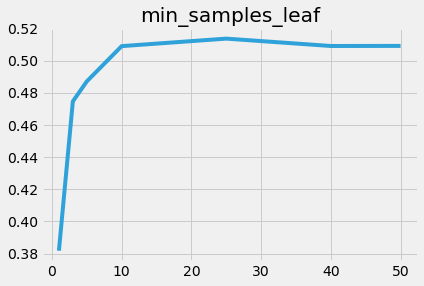

In [137]:
d={'n_estimators':1000, 'n_jobs':-1}
p='min_samples_leaf'
v=[1,3,5,10,25,40,50]
check_parameters(p,v,d)

Fitting with max_features=log2
CPU times: user 3.11 s, sys: 1.35 s, total: 4.46 s
Wall time: 3.77 s
ROC AUC Score 0.8473358792507728
F1 0.40476190476190477
Auc 0.4080089764966912

Fitting with max_features=sqrt
CPU times: user 3.13 s, sys: 1.35 s, total: 4.48 s
Wall time: 3.82 s
ROC AUC Score 0.8479420500697097
F1 0.3764705882352941
Auc 0.40842424794290033

Fitting with max_features=0.1
CPU times: user 2.77 s, sys: 1.18 s, total: 3.95 s
Wall time: 3.94 s
ROC AUC Score 0.8287870521913074
F1 0.2622950819672131
Auc 0.37387582652230755

Fitting with max_features=0.3
CPU times: user 3.07 s, sys: 1.3 s, total: 4.37 s
Wall time: 3.68 s
ROC AUC Score 0.8485482208886463
F1 0.40449438202247195
Auc 0.40536943760612604

Fitting with max_features=0.9
CPU times: user 3.73 s, sys: 1.34 s, total: 5.07 s
Wall time: 3.63 s
ROC AUC Score 0.8456386009577499
F1 0.3373493975903615
Auc 0.382936522140389



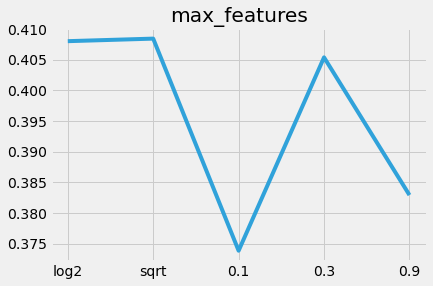

In [55]:
d={'n_estimators':1000,'n_jobs':-1,'min_samples_leaf':10}
p='max_features'
v=['log2','sqrt', .1, .3, .9]
check_parameters(p,v,d)

Fitting with class_weight=balanced
CPU times: user 3.02 s, sys: 1.35 s, total: 4.37 s
Wall time: 3.76 s
ROC AUC Score 0.8514578408195429
F1 0.435374149659864
Auc 0.408857564632372

Fitting with class_weight=balanced_subsample
CPU times: user 4.36 s, sys: 2.23 s, total: 6.59 s
Wall time: 5.05 s
ROC AUC Score 0.8510335212462872
F1 0.452054794520548
Auc 0.40353287352783507



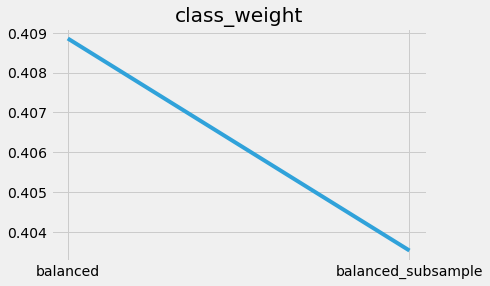

In [56]:
d={'n_estimators':1000,'n_jobs':-1,'min_samples_leaf':10,'max_features': 'sqrt'}
p='class_weight'
v=['balanced', 'balanced_subsample']
check_parameters(p,v,d)

In [138]:
d={'n_estimators':1000,'n_jobs':-1,'min_samples_leaf':10,'max_features':'sqrt',
   'class_weight':'balanced', 'random_state':428}

In [139]:
model=RandomForestClassifier(**d)
%time model.fit(X_train,y_train)

CPU times: user 3.28 s, sys: 1.45 s, total: 4.72 s
Wall time: 3.54 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=428, verbose=0,
                       warm_start=False)


    Training ROC_AUC :0.9205759732003129
    Training F1 : 0.6203007518796992
    Training AUC: 0.7405496762623348

    Validation ROC_AUC: 0.8971559574195203
    Validation F1: 0.5065502183406113
    Validation AUC: 0.5072933541963939

    
True Negatives: 350
False Positives: 102
False Negatives 11
True Positives: 58
Recall: 0.8405797101449275
Precision: 0.3625


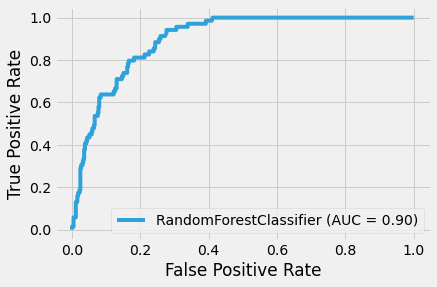

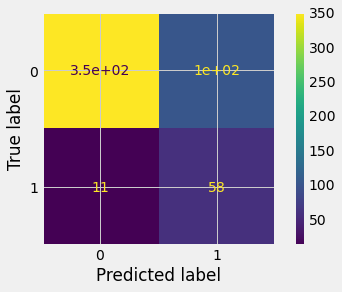

In [140]:
print_report(model,train,valid,'has_gathered_two_customers')

In [141]:
df.has_gathered_two_customers.value_counts()

0    1826
1     261
Name: has_gathered_two_customers, dtype: int64

In [142]:
train.has_gathered_two_customers.value_counts()

0    852
1    192
Name: has_gathered_two_customers, dtype: int64

In [143]:
perm=permutation_importance(model,X_train,y_train,n_repeats=5,n_jobs=-1)
perm=pd.DataFrame({'importance':perm['importances_mean']},index=X_train.columns)
perm.sort_values(by=['importance'],inplace=True)

<AxesSubplot:>

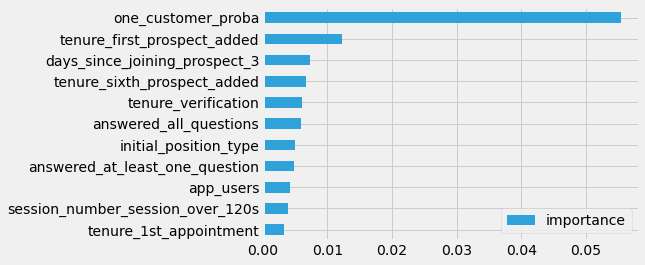

In [145]:
perm[perm.importance>0.002].plot(kind='barh')

<AxesSubplot:>

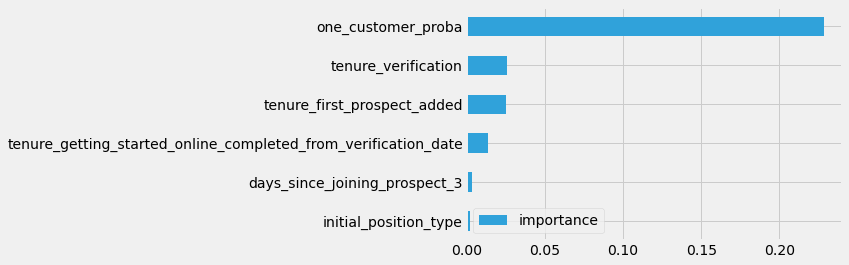

In [188]:
perm[perm.importance>0.002].plot(kind='barh')

In [177]:
perm_features=perm[perm.importance>0.002].index.tolist()
#Removing as it is a duplicate of `tenure_getting_started_online_completed`
# perm_features.remove('days_since_joining_prospect_1')
# perm_features.remove('days_since_joining_prospect_9')

In [190]:
d

{'n_estimators': 1000,
 'n_jobs': -1,
 'min_samples_leaf': 10,
 'max_features': 0.9,
 'class_weight': 'balanced',
 'random_state': 428}

In [191]:
model=RandomForestClassifier(**d)
%time model.fit(X_train[perm_features],y_train)

CPU times: user 3.9 s, sys: 1.3 s, total: 5.2 s
Wall time: 5.92 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=0.9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=428, verbose=0,
                       warm_start=False)


    Training ROC_AUC :0.9387225548902196
    Training F1 : 0.6967213114754098
    Training AUC: 0.7889258763992059

    Validation ROC_AUC: 0.8512087000892972
    Validation F1: 0.46728971962616817
    Validation AUC: 0.4896144034386262

    
True Negatives: 371
False Positives: 97
False Negatives 17
True Positives: 50
Recall: 0.746268656716418
Precision: 0.3401360544217687


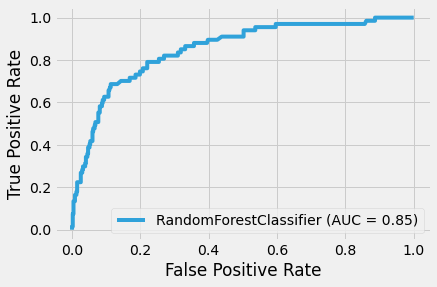

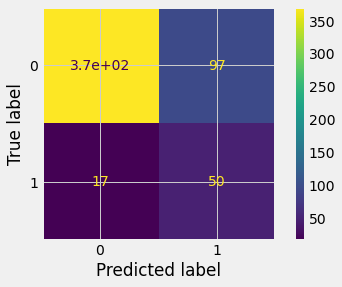

In [192]:
print_report(model,train,valid,'has_gathered_two_customers',perm_features)

### SAVE RF model

In [91]:
X_train.columns

Index(['tenure_sixth_prospect_added', 'tenure_first_prospect_added',
       'tenure_verification', 'tenure_getting_started_online_completed',
       'app_users',
       'tenure_getting_started_online_completed_from_verification_date',
       'session_number_session_over_120s', 'total_sessions_last_7d',
       'total_sessions_last_30d', 'initial_position_type', 'actively_skipped',
       'answered_at_least_one_question', 'answered_all_questions',
       'is_customer', 'days_since_joining_prospect_3',
       'tenure_1st_appointment', 'one_customer_proba'],
      dtype='object')

In [194]:
from datetime import datetime

In [198]:
suffix=str(datetime.now().strftime('%Y-%m-%d'))
model_name='_'.join(['model_rf_2_customer',suffix,'.pkl'])

In [204]:
with open(os.path.join(os.getcwd(),model_name),'wb') as f:
    joblib.dump(model,f)

In [178]:
perm_features

['tenure_getting_started_online_completed',
 'total_sessions_last_7d',
 'total_sessions_last_30d',
 'tenure_sixth_prospect_added',
 'days_since_joining_prospect_3',
 'tenure_first_prospect_added',
 'tenure_getting_started_online_completed_from_verification_date',
 'tenure_verification',
 'one_customer_proba']

In [ ]:
model_2_cus=joblib.load('model_rf_2_customer_2021-06-29_.pkl')

In [59]:
%time model_2_cus.fit(X_train,y_train)

CPU times: user 4.42 s, sys: 713 ms, total: 5.13 s
Wall time: 7.77 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=0.9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=428, verbose=0,
                       warm_start=False)


    Training ROC_AUC :0.9400961697894213
    Training F1 : 0.7132867132867132
    Training AUC: 0.800859143084399

    Validation ROC_AUC: 0.8572760572760574
    Validation F1: 0.4912280701754387
    Validation AUC: 0.42068546970127174

    
True Negatives: 398
False Positives: 64
False Negatives 23
True Positives: 42
Recall: 0.6461538461538462
Precision: 0.39622641509433965


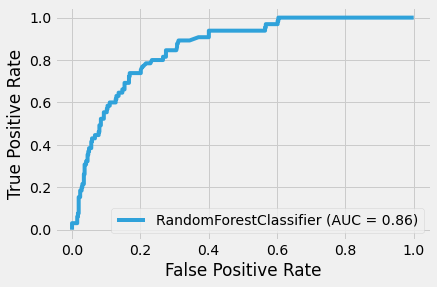

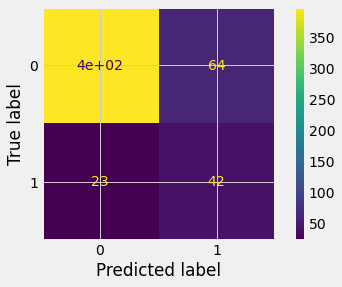

In [60]:
print_report(model_2_cus,train,valid,'has_gathered_two_customers',X_train.columns)

## Manually Tune Model Threshold

In [82]:
model_2_cus.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=0.9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=428, verbose=0,
                       warm_start=False)

In [83]:
y_pred=model_2_cus.predict(X_valid)

In [109]:
def conf_matrix(y,pred):
    ((tn, fp), (fn, tp)) = confusion_matrix(y, pred)
    ((tnr,fpr),(fnr,tpr))= confusion_matrix(y, pred, 
            normalize='true')
    return pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', 
                                f'FP = {fp} (FPR = {fpr:1.2%})'], 
                         [f'FN = {fn} (FNR = {fnr:1.2%})', 
                                f'TP = {tp} (TPR = {tpr:1.2%})']],
            index=['True 0', 'True 1(Two Customers)'], 
            columns=['Pred 0', 
                            'Pred 1(Acquired Two Customers)'])

In [160]:
pred_prob=model_2_cus.predict_proba(X_train)[:,1]
fpr,tpr,thresholds=roc_curve(y_train,pred_prob)
dfplot=pd.DataFrame({'Threshold':thresholds,'False Positive Rate':fpr,
             'False Negative Rate':1.-tpr})

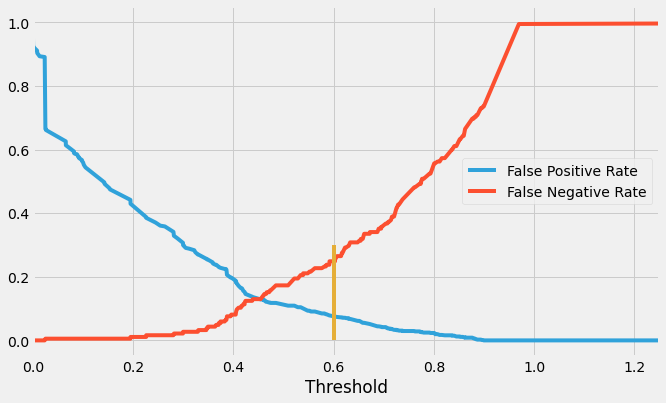

In [164]:
ax=dfplot.plot(x='Threshold',y=['False Positive Rate','False Negative Rate'],
           figsize=(10,6))

ax.plot([0.60,0.60],[0,0.3])
ax.set_xbound(0,1.25)

In [168]:
valid_pred_prob=model_2_cus.predict_proba(X_valid)[:,1]

In [169]:
tuned_thresh=np.where(valid_pred_prob>=0.60,1,0)

In [166]:
conf_matrix(y_valid,y_pred)

,Pred 0,Pred 1(Acquired Two Customers)
True 0,TN = 398 (TNR = 86.15%),FP = 64 (FPR = 13.85%)
True 1(Two Customers),FN = 23 (FNR = 35.38%),TP = 42 (TPR = 64.62%)


In [170]:
conf_matrix(y_valid,tuned_thresh)

,Pred 0,Pred 1(Acquired Two Customers)
True 0,TN = 415 (TNR = 89.83%),FP = 47 (FPR = 10.17%)
True 1(Two Customers),FN = 29 (FNR = 44.62%),TP = 36 (TPR = 55.38%)


### Model Results EDA

In [254]:
model_2_cus=joblib.load('model_rf_2_customer_2021-06-29_.pkl')

In [255]:
model=model_2_cus

In [256]:
perm_features=['tenure_getting_started_online_completed',
 'total_sessions_last_7d',
 'total_sessions_last_30d',
 'tenure_sixth_prospect_added',
 'days_since_joining_prospect_3',
 'tenure_first_prospect_added',
 'tenure_getting_started_online_completed_from_verification_date',
 'tenure_verification',
 'one_customer_proba']

In [257]:
model.fit(X_train[perm_features],y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=0.9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=428, verbose=0,
                       warm_start=False)


    Training ROC_AUC :0.9351616994292962
    Training F1 : 0.6650943396226415
    Training AUC: 0.7542105090438407

    Validation ROC_AUC: 0.8653292551277438
    Validation F1: 0.4571428571428572
    Validation AUC: 0.4825752676590691

    
True Negatives: 318
False Positives: 79
False Negatives 16
True Positives: 40
Recall: 0.7142857142857143
Precision: 0.33613445378151263


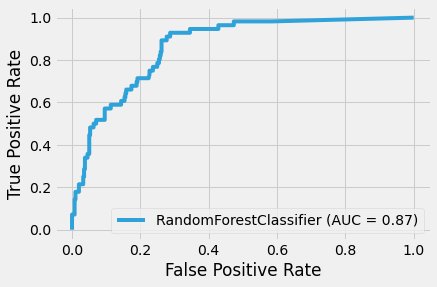

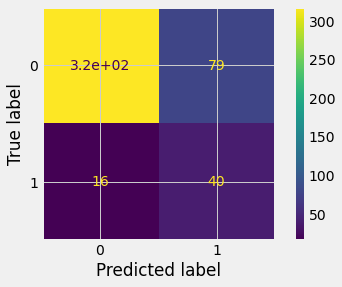

In [258]:
print_report(model,train,valid,'has_gathered_two_customers',perm_features)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_inter_ax': <AxesSubplot:xlabel='tenure_getting_started_online_completed', ylabel='tenure_1st_appointment'>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


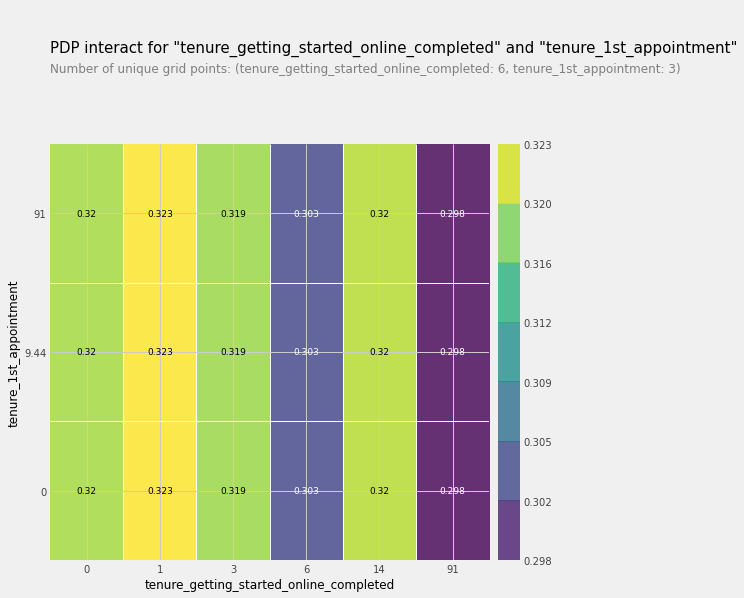

In [183]:
# Day 6 complete online training decreases chance to get 2nd customer
p=pdp.pdp_interact(model,X_train.sample(300),perm_features,['tenure_getting_started_online_completed',
                                                          
                                'tenure_1st_appointment'],num_grid_points=[10,10],n_jobs=4)
pdp.pdp_interact_plot(p,feature_names=['tenure_getting_started_online_completed',
                                                          
                                'tenure_1st_appointment'],x_quantile=True,ncols=2,plot_type='grid')

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_inter_ax': <AxesSubplot:xlabel='tenure_getting_started_online_completed', ylabel='tenure_1st_appointment'>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


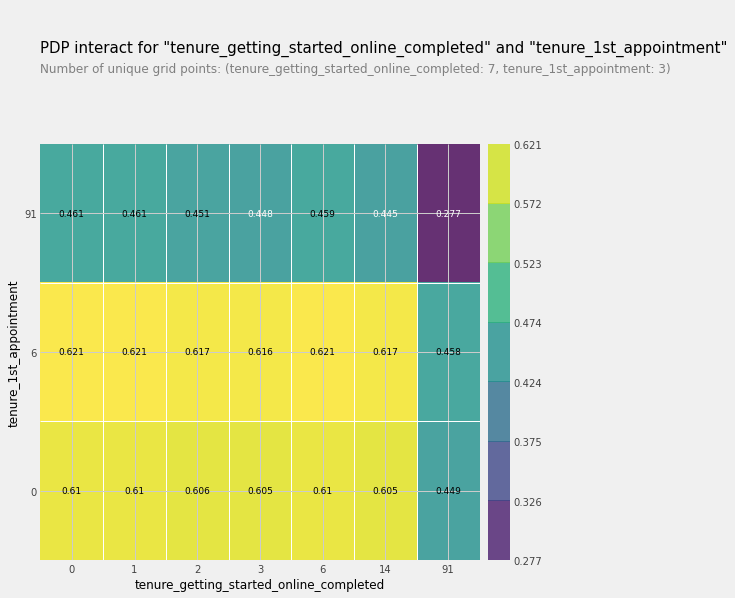

In [113]:
p=pdp.pdp_interact(model,X_train.sample(300),perm_features,['tenure_getting_started_online_completed',
                                                          
                                'tenure_1st_appointment'],num_grid_points=[10,10],n_jobs=4)
pdp.pdp_interact_plot(p,feature_names=['tenure_getting_started_online_completed',
                                                          
                                'tenure_1st_appointment'],x_quantile=True,ncols=2,plot_type='grid')

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_inter_ax': <AxesSubplot:xlabel='tenure_getting_started_online_completed', ylabel='tenure_getting_started_online_completed_from_verification_date'>})

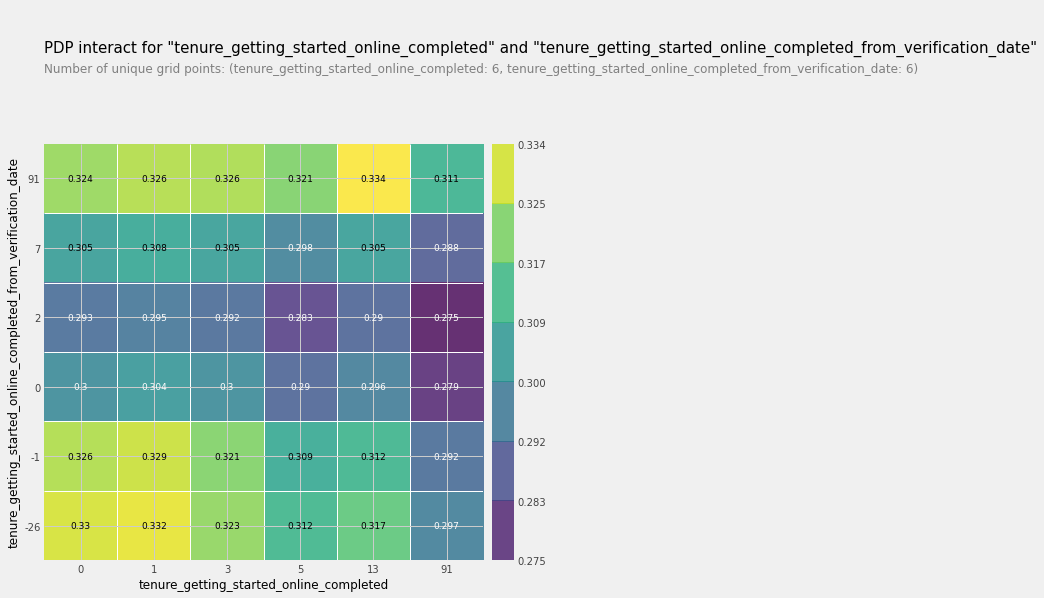

In [184]:
p=pdp.pdp_interact(model,X_train.sample(300),perm_features,['tenure_getting_started_online_completed',
                                                          
                                'tenure_getting_started_online_completed_from_verification_date'],num_grid_points=[10,10],n_jobs=4)
pdp.pdp_interact_plot(p,feature_names=['tenure_getting_started_online_completed',
                                                          
                                'tenure_getting_started_online_completed_from_verification_date'],x_quantile=True,ncols=2,plot_type='grid')

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_inter_ax': <AxesSubplot:xlabel='tenure_getting_started_online_completed', ylabel='tenure_getting_started_online_completed_from_verification_date'>})

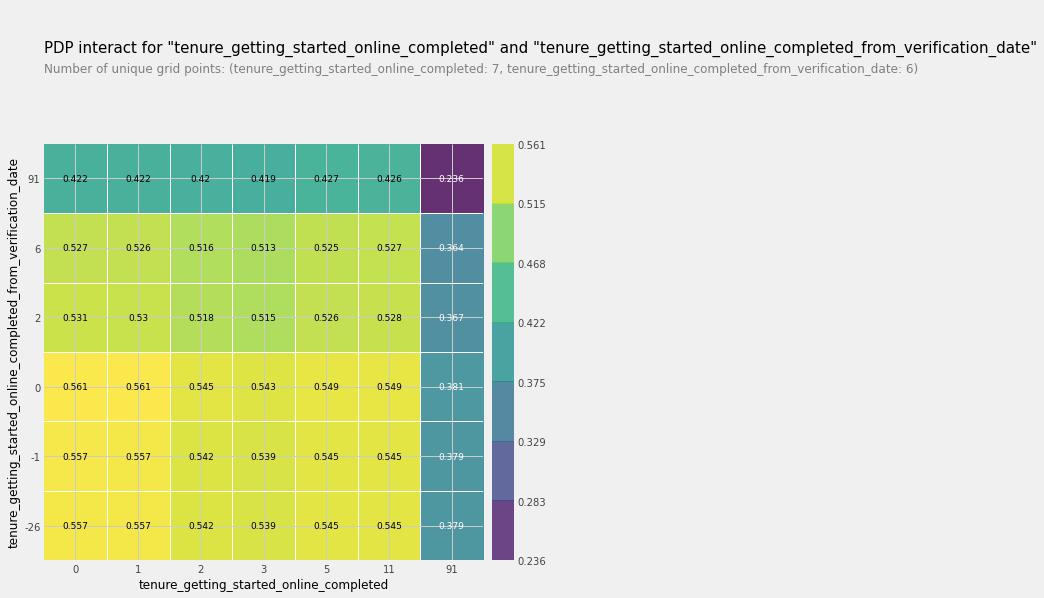

In [114]:
p=pdp.pdp_interact(model,X_train.sample(300),perm_features,['tenure_getting_started_online_completed',
                                                          
                                'tenure_getting_started_online_completed_from_verification_date'],num_grid_points=[10,10],n_jobs=4)
pdp.pdp_interact_plot(p,feature_names=['tenure_getting_started_online_completed',
                                                          
                                'tenure_getting_started_online_completed_from_verification_date'],x_quantile=True,ncols=2,plot_type='grid')

In [185]:
shap_values=shap.TreeExplainer(model).shap_values(X_train)

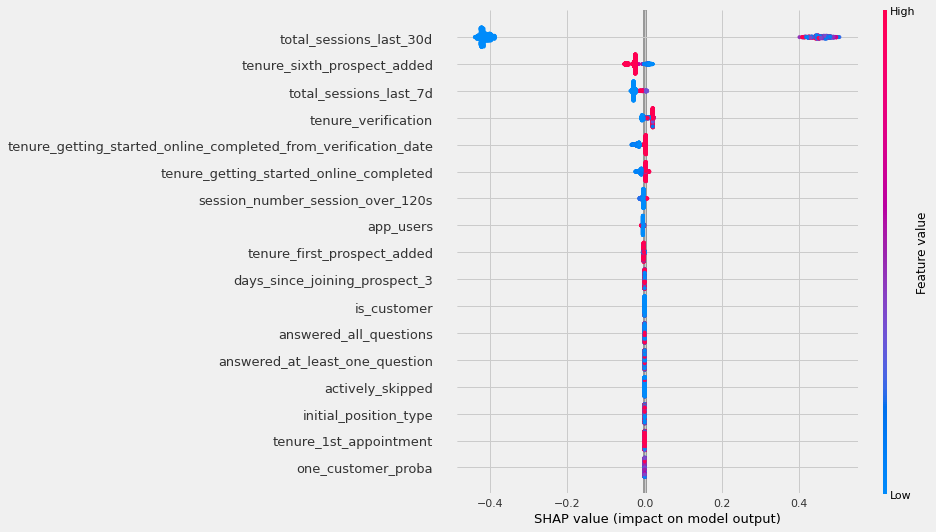

In [186]:
shap.summary_plot(shap_values[1],X_train)

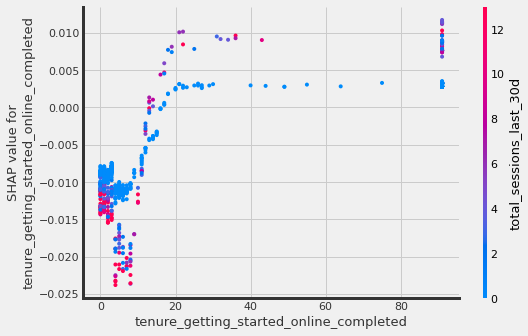

In [187]:
shap.dependence_plot('tenure_getting_started_online_completed',shap_values[1],X_train)

In [188]:
shap.initjs()

In [189]:
X_output= X_valid[perm_features].copy()
y_pred=model.predict(X_valid[perm_features])
X_output.loc[:,'predict']=np.round(y_pred,2)

In [190]:
def shap_plot(j):
    explainerModel=shap.TreeExplainer(model)
    shap_values_model=explainerModel.shap_values(X_output)
    p=shap.force_plot(explainerModel.expected_value[0],
                    shap_values_model[0][j],X_output.iloc[[j]])
    return(p)

In [191]:
shap_plot(100)

In [67]:
model_df_copy.columns

Index(['tenure_sixth_prospect_added', 'tenure_first_prospect_added',
       'tenure_verification', 'tenure_getting_started_online_completed',
       'app_users',
       'tenure_getting_started_online_completed_from_verification_date',
       'session_number_session_over_120s', 'total_sessions_last_7d',
       'total_sessions_last_30d', 'initial_position_type', 'actively_skipped',
       'answered_at_least_one_question', 'answered_all_questions',
       'is_customer', 'days_since_joining_prospect_2',
       'days_since_joining_prospect_3', 'tenure_1st_appointment',
       'has_gathered_two_customers', 'one_customer_proba'],
      dtype='object')

In [68]:
df['has_gathered_one_customer']=np.where(df.first_customer_gathered_excluding_self_date.notnull(),1,0)

(array([0, 1]),
 [Text(0, 0, 'has_gathered_one_customer'),
  Text(1, 0, 'has_gathered_two_customers')])

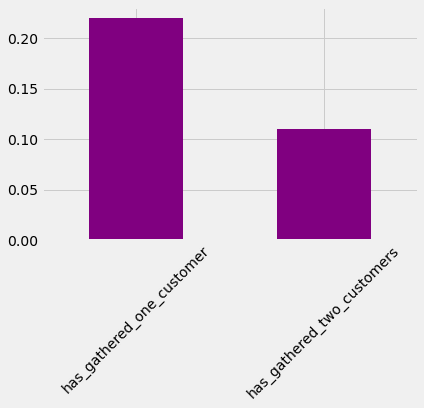

In [69]:
## 22% partners gathered one customer, half of them gathered two customers
np.round(df[['has_gathered_one_customer','has_gathered_two_customers']].sum()/df.shape[0],2).plot(kind='bar',color='purple')
plt.xticks(rotation=45)

In [70]:
from datetime import datetime

In [71]:
today_date=pd.to_datetime(datetime.now().strftime('%Y-%m-%d'))
column_list=[c for c in df.columns if 'tenure' not in c]
survival_df=df[column_list].copy()

In [72]:
date_cols=[ c for c in survival_df.columns if 'date' in c]
days_cols=[c for c in survival_df.columns if 'days' in c]

In [73]:
for c in date_cols:
    survival_df[f'has_'+c]=survival_df[c].notnull()
for c in days_cols:
    survival_df[f'has_'+c]=survival_df[c].notnull()

In [74]:

for c in date_cols:
    survival_df[c]=survival_df[c].fillna(today_date)

for c in days_cols:
    survival_df[c]=survival_df[c].fillna(91)

In [75]:
for c in date_cols:

    title=re.sub('_date','',c)
    survival_df.loc[:,'tenure_'+title]=abs(survival_df[c]-survival_df.started_at)
    print(c)

sixth_prospect_added_date
first_prospect_added_date
verification_date
getting_started_online_completed_date
first_application_date
first_customer_gathered_excluding_self_date
second_customer_gathered_excluding_self_date
first_gathered_six_personal_customers_date
pro_graduation_date
became_pro_graduation_eligible_date
customer_1_gathered_date
customer_2_gathered_date
customer_3_gathered_date
customer_4_gathered_date
customer_5_gathered_date
customer_6_gathered_date
customer_7_gathered_date
customer_8_gathered_date
customer_9_gathered_date
customer_10_gathered_date


In [76]:
median_lifetime=dict()

In [77]:
def fit_cumulative_density_plot(df,col1,col2,prefix=None):
    kmf=KaplanMeierFitter()
    if df[col1].dtype !='float64':
        kmf.fit(df[col1].dt.days,df[col2],label=prefix+' '+re.sub('tenure |days ','',col1))
    else:
        kmf.fit(df[col1],df[col2],label=prefix+' '+re.sub('tenure |days ','',col1))
    
    title=re.sub('tenure |days ','',col1)
    median_lifetime[prefix+title+' _median_lifetime']=kmf.median_survival_time_
    kmf.plot_cumulative_density(figsize=(10,8),ci_legend=True)

In [78]:
tenure_list=[c for c in survival_df.columns if 'tenure' in c  or 'days' in c]

In [79]:
one_customer_df=survival_df[(survival_df.has_gathered_one_customer==1)&(survival_df.has_gathered_two_customers!=1)]
two_customer_df=survival_df[survival_df.has_gathered_two_customers==1]

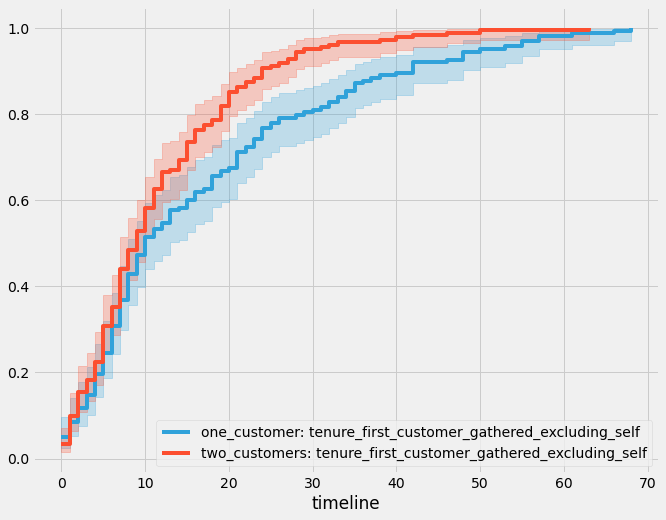

In [80]:
fit_cumulative_density_plot(one_customer_df,'tenure_first_customer_gathered_excluding_self','has_gathered_one_customer','one_customer:')
fit_cumulative_density_plot(two_customer_df,'tenure_first_customer_gathered_excluding_self','has_gathered_one_customer','two_customers:')

In [51]:
# [c for c in one_customer_df.columns if 'tenure' in c]

In [52]:
# [c for c in one_customer_df.columns if 'has' in c]

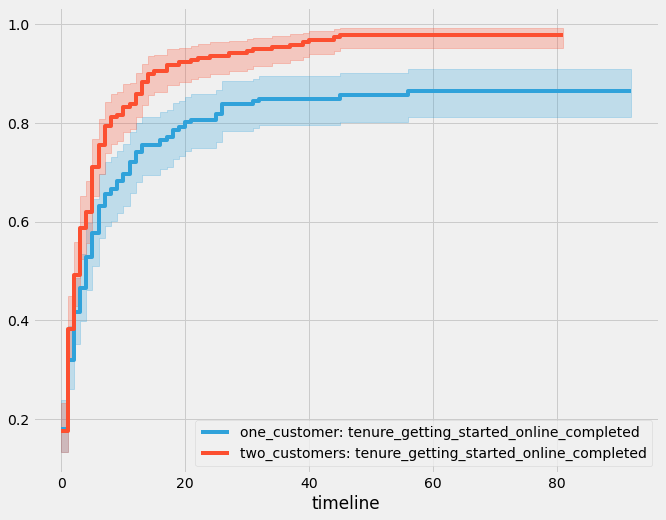

In [114]:
fit_cumulative_density_plot(one_customer_df,'tenure_getting_started_online_completed','has_getting_started_online_completed_date','one_customer:')
fit_cumulative_density_plot(two_customer_df,'tenure_getting_started_online_completed','has_getting_started_online_completed_date','two_customers:')

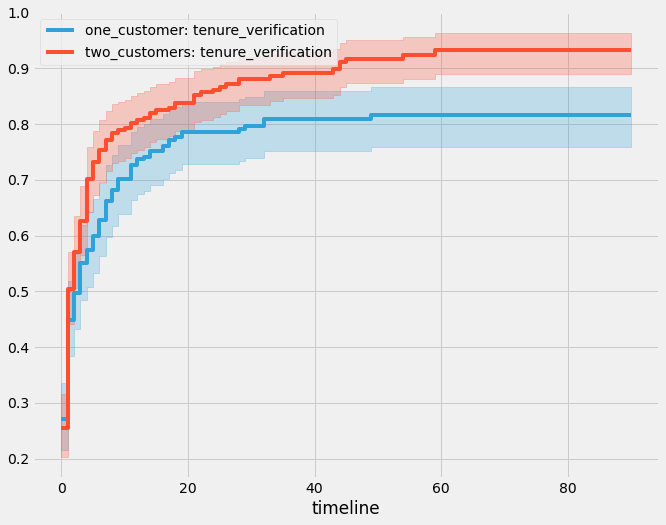

In [115]:
fit_cumulative_density_plot(one_customer_df,'tenure_verification','has_verification_date','one_customer:')
fit_cumulative_density_plot(two_customer_df,'tenure_verification','has_verification_date','two_customers:')

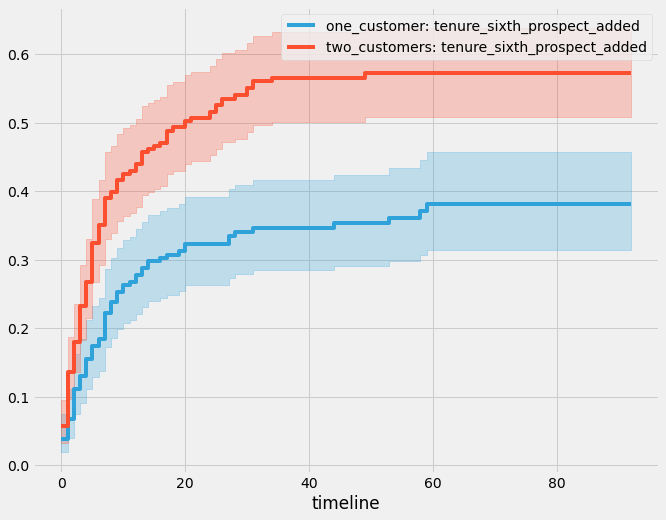

In [116]:
fit_cumulative_density_plot(one_customer_df,'tenure_sixth_prospect_added','has_sixth_prospect_added_date','one_customer:')
fit_cumulative_density_plot(two_customer_df,'tenure_sixth_prospect_added','has_sixth_prospect_added_date','two_customers:')

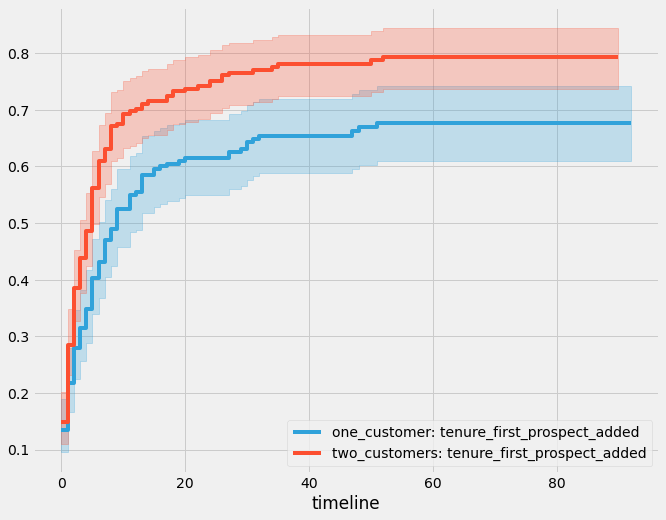

In [117]:
fit_cumulative_density_plot(one_customer_df,'tenure_first_prospect_added','has_first_prospect_added_date','one_customer:')
fit_cumulative_density_plot(two_customer_df,'tenure_first_prospect_added','has_first_prospect_added_date','two_customers:')

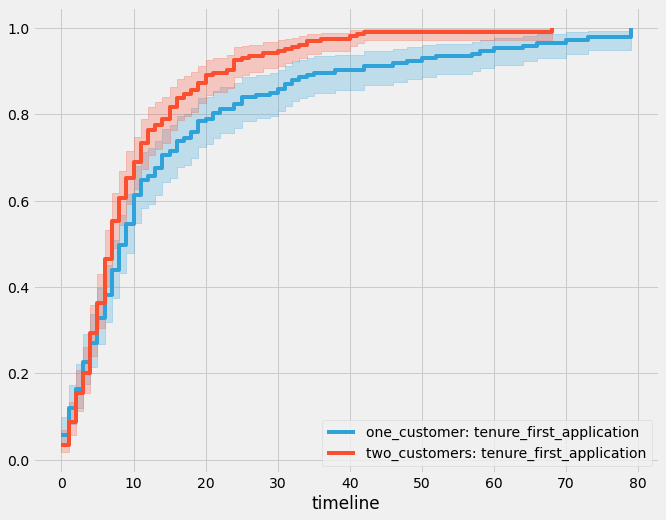

In [118]:
fit_cumulative_density_plot(one_customer_df,'tenure_first_application','has_first_application_date','one_customer:')
fit_cumulative_density_plot(two_customer_df,'tenure_first_application','has_first_application_date','two_customers:')

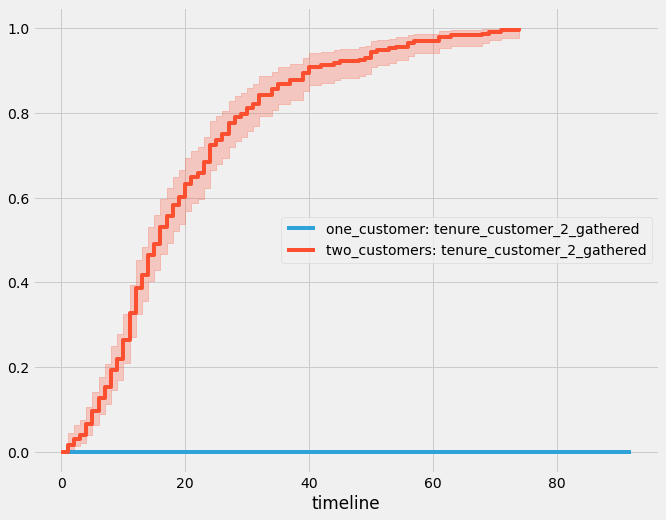

In [155]:
fit_cumulative_density_plot(one_customer_df,'tenure_customer_2_gathered','has_gathered_two_customers','one_customer:')
fit_cumulative_density_plot(two_customer_df,'tenure_customer_2_gathered','has_gathered_two_customers','two_customers:')

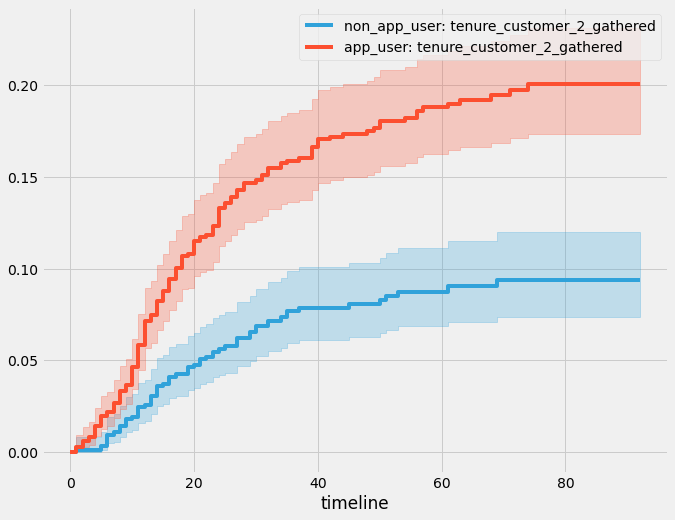

In [194]:

fit_cumulative_density_plot(survival_df.loc[survival_df.app_users==0],'tenure_customer_2_gathered','has_gathered_two_customers','non_app_user:')
fit_cumulative_density_plot(survival_df.loc[survival_df.app_users==1],'tenure_customer_2_gathered','has_gathered_two_customers','app_user:')


In [161]:
survival_df.loc[survival_df.app_users==1,'has_gathered_one_customer'].sum()/survival_df.loc[survival_df.app_users==1].shape[0]

0.0

In [162]:
survival_df.loc[survival_df.app_users==0,'has_gathered_one_customer'].sum()/survival_df.loc[survival_df.app_users==0].shape[0]

0.15358361774744028

In [169]:
survival_df.loc[survival_df.app_users==1,'has_gathered_two_customers'].sum()/survival_df.loc[survival_df.app_users==1].shape[0]

0.1663286004056795

In [170]:
survival_df.loc[survival_df.app_users==0,'has_gathered_two_customers'].sum()/survival_df.loc[survival_df.app_users==0].shape[0]

0.07281001137656427

In [ ]:
survival_df.loc[survival_df.app_users==0,'has_gathered_two_customers']

In [175]:
df.first_gathered_six_personal_customers_date.notnull().sum()/df.shape[0]

0.0193029490616622

In [302]:
pd.DataFrame(pd.Series(median_lifetime),columns=['median'])

,median
one_customer:tenure_getting_started_online_completed _median_lifetime,4.0
two_customers:tenure_getting_started_online_completed _median_lifetime,3.0
one_customer:tenure_sixth_prospect_added _median_lifetime,inf
two_customers:tenure_sixth_prospect_added _median_lifetime,29.0
one_customer:tenure_first_customer_gathered_excluding_self _median_lifetime,10.0
two_customers:tenure_first_customer_gathered_excluding_self _median_lifetime,9.0
one_customer:tenure_verification _median_lifetime,3.0
two_customers:tenure_verification _median_lifetime,2.0
one_customer:tenure_first_prospect_added _median_lifetime,11.0
two_customers:tenure_first_prospect_added _median_lifetime,5.0


In [126]:
print('mean',df.loc[df.has_gathered_two_customers==1,['tenure_verification','tenure_getting_started_online_completed',
                            'tenure_first_prospect_added','tenure_sixth_prospect_added',
                            'tenure_first_application','tenure_1st_appointment','tenure_first_customer_gathered_excluding_self','tenure_customer_2_gathered']].mean())
print('median',df.loc[df.has_gathered_two_customers==1,['tenure_verification','tenure_getting_started_online_completed',
                            'tenure_first_prospect_added','tenure_sixth_prospect_added',
                            'tenure_first_application','tenure_1st_appointment','tenure_first_customer_gathered_excluding_self','tenure_customer_2_gathered']].median())


mean tenure_verification                               5.028846
tenure_getting_started_online_completed           5.274775
tenure_first_prospect_added                       5.407821
tenure_sixth_prospect_added                       7.843750
tenure_first_application                          9.770925
tenure_1st_appointment                            8.465517
tenure_first_customer_gathered_excluding_self    11.640351
tenure_customer_2_gathered                       16.904762
dtype: float64
median tenure_verification                               1.0
tenure_getting_started_online_completed           2.0
tenure_first_prospect_added                       3.0
tenure_sixth_prospect_added                       5.0
tenure_first_application                          7.0
tenure_1st_appointment                            6.0
tenure_first_customer_gathered_excluding_self     9.0
tenure_customer_2_gathered                       14.0
dtype: float64


Text(0.5, 1.0, 'Partners Gathered Two Customers Journey')

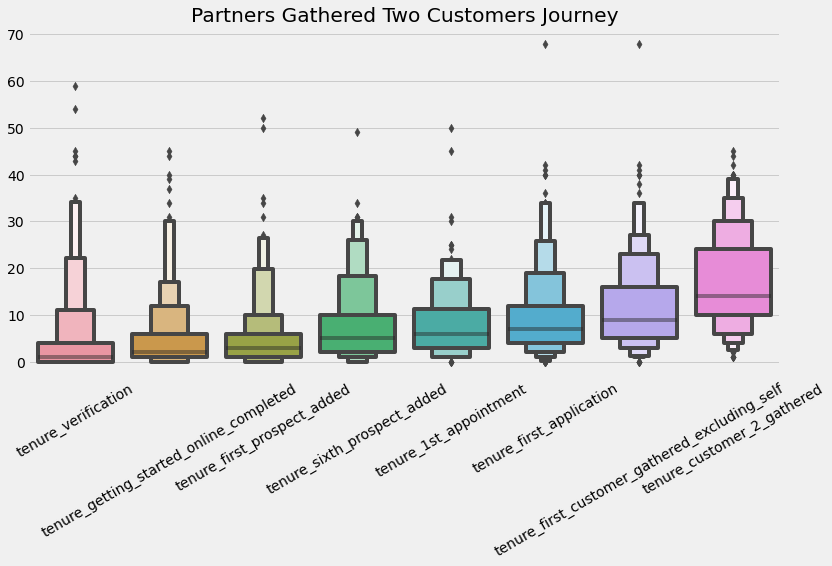

In [125]:
plt.figure(figsize=(12,6))
sns.boxenplot(data=df.loc[df.has_gathered_two_customers==1,['tenure_verification','tenure_getting_started_online_completed',
                            'tenure_first_prospect_added','tenure_sixth_prospect_added',
                           'tenure_1st_appointment','tenure_first_application','tenure_first_customer_gathered_excluding_self','tenure_customer_2_gathered']])
plt.xticks(rotation=30)
plt.title('Partners Gathered Two Customers Journey')

Text(0.5, 1.0, 'Partners Gathered One Customers Only Journey')

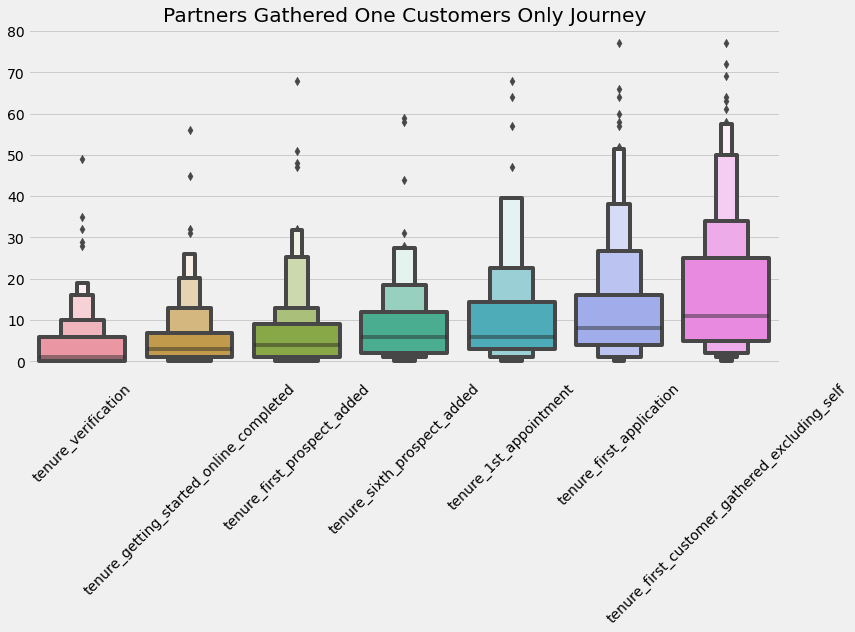

In [42]:
plt.figure(figsize=(12,6))
sns.boxenplot(data=df.loc[(df.has_gathered_two_customers==0)&(df.has_gathered_one_customer==1),['tenure_verification','tenure_getting_started_online_completed',
                            'tenure_first_prospect_added','tenure_sixth_prospect_added','tenure_1st_appointment',
                            'tenure_first_application','tenure_first_customer_gathered_excluding_self']])
plt.xticks(rotation=45)
plt.title('Partners Gathered One Customers Only Journey')

In [260]:
df=tenure_compute(df,['customer_2_gathered_date'],'first_customer_gathered_excluding_self_date')
df['tenure_customer_2_gathered_from_first_customer_gathered_excluding_self_date']=df.tenure_customer_2_gathered_from_first_customer_gathered_excluding_self_date.dt.days

In [261]:
print('mean',df.tenure_customer_2_gathered_from_first_customer_gathered_excluding_self_date.mean())
print('median',df.tenure_customer_2_gathered_from_first_customer_gathered_excluding_self_date.median())
print('80%',df.tenure_customer_2_gathered_from_first_customer_gathered_excluding_self_date.quantile(0.8))

mean 8.4009009009009
median 4.0
80% 14.0


Text(0, 40, 'median')

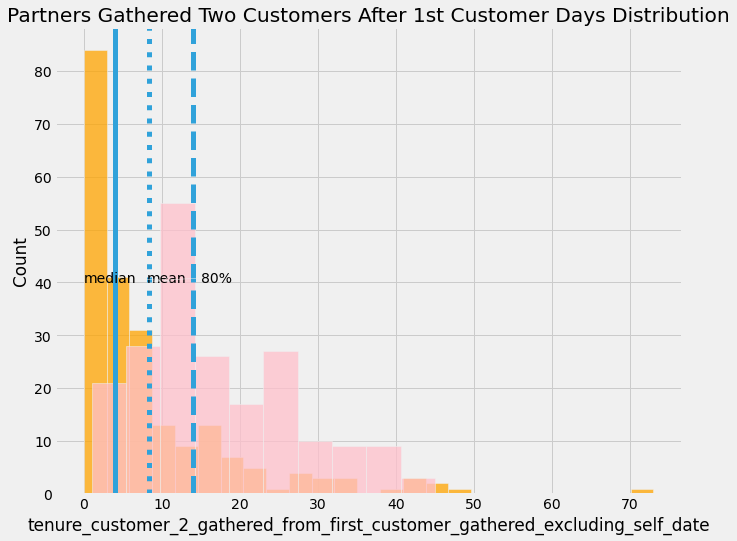

In [281]:
f,ax=plt.subplots(figsize=(10,8))
sns.histplot(df.tenure_customer_2_gathered_from_first_customer_gathered_excluding_self_date,color='orange',ax=ax)
sns.histplot(df.tenure_customer_2_gathered,ax=ax,color='pink')
ax.axvline(df.tenure_customer_2_gathered_from_first_customer_gathered_excluding_self_date.mean(),linestyle=':',linewidth=5)
ax.axvline(df.tenure_customer_2_gathered_from_first_customer_gathered_excluding_self_date.median(),linewidth=5)
ax.axvline(df.tenure_customer_2_gathered_from_first_customer_gathered_excluding_self_date.quantile(0.8),linestyle='--',linewidth=5)
ax.set_title('Partners Gathered Two Customers After 1st Customer Days Distribution')
ax.annotate('mean', xy=(10, 40), xytext=(8, 40), 
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
ax.annotate('80%', xy=(10, 40), xytext=(15, 40), 
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
ax.annotate('median', xy=(10, 40), xytext=(0, 40), 
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

In [ ]:
f,ax=plt.subplots(figsize=(10,8))
sns.kdeplot(df.tenure_customer_2_gathered_from_first_customer_gathered_excluding_self_date,shade=True,ax=ax)
sns.kdeplot(df.tenure_customer_2_gathered,shade=False,ax=ax,color='pink')
ax.axvline(df.tenure_customer_2_gathered_from_first_customer_gathered_excluding_self_date.mean(),linestyle=':',linewidth=5)
ax.axvline(df.tenure_customer_2_gathered_from_first_customer_gathered_excluding_self_date.median(),linewidth=5)
ax.axvline(df.tenure_customer_2_gathered_from_first_customer_gathered_excluding_self_date.quantile(0.8),linestyle='--',linewidth=5)
ax.set_title('Partners Gathered Two Customers After 1st Customer Days Distribution')
ax.annotate('mean', xy=(10, 0.03), xytext=(8, 0.03), 
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
ax.annotate('80%', xy=(10, 0.03), xytext=(15, 0.04), 
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
ax.annotate('median', xy=(10, 0.03), xytext=(0, 0.02), 
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

Text(0, 0.02, 'median')

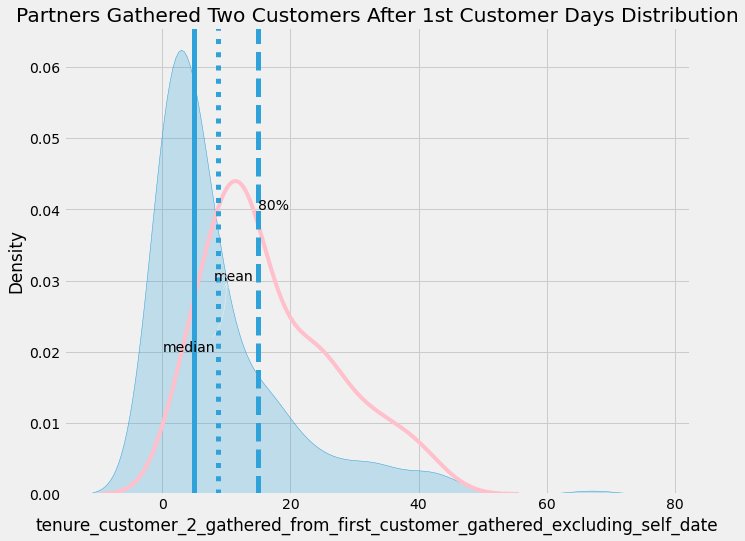

In [157]:
f,ax=plt.subplots(figsize=(10,8))
sns.kdeplot(df.tenure_customer_2_gathered_from_first_customer_gathered_excluding_self_date,shade=True,ax=ax)
sns.kdeplot(df.tenure_customer_2_gathered,shade=False,ax=ax,color='pink')
ax.axvline(df.tenure_customer_2_gathered_from_first_customer_gathered_excluding_self_date.mean(),linestyle=':',linewidth=5)
ax.axvline(df.tenure_customer_2_gathered_from_first_customer_gathered_excluding_self_date.median(),linewidth=5)
ax.axvline(df.tenure_customer_2_gathered_from_first_customer_gathered_excluding_self_date.quantile(0.8),linestyle='--',linewidth=5)
ax.set_title('Partners Gathered Two Customers After 1st Customer Days Distribution')
ax.annotate('mean', xy=(10, 0.03), xytext=(8, 0.03), 
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
ax.annotate('80%', xy=(10, 0.03), xytext=(15, 0.04), 
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
ax.annotate('median', xy=(10, 0.03), xytext=(0, 0.02), 
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

In [63]:
# df.tenure_customer_2_gathered_from_first_customer_gathered_excluding_self_date.hist(bins=50)

In [144]:
vis_df=df.copy()

In [145]:
for c in ['actively_skipped',
       'answered_at_least_one_question', 'answered_all_questions']:
    vis_df[c]=vis_df[c].fillna(False)

In [149]:
df_one_c=vis_df.loc[vis_df.has_gathered_one_customer==1]

<Figure size 432x288 with 0 Axes>

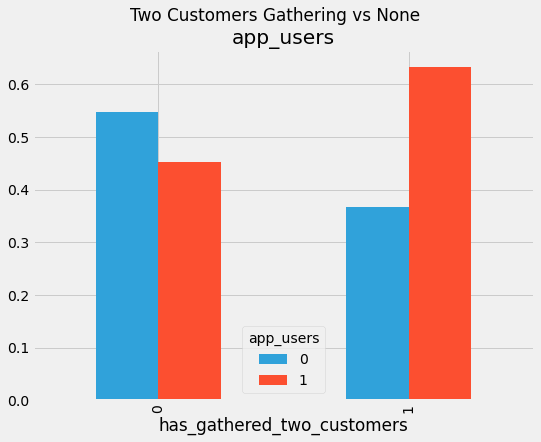

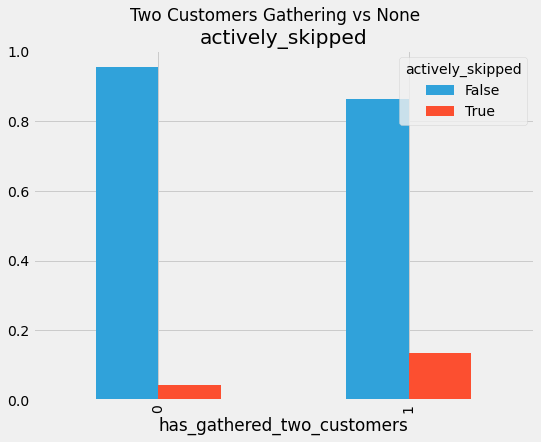

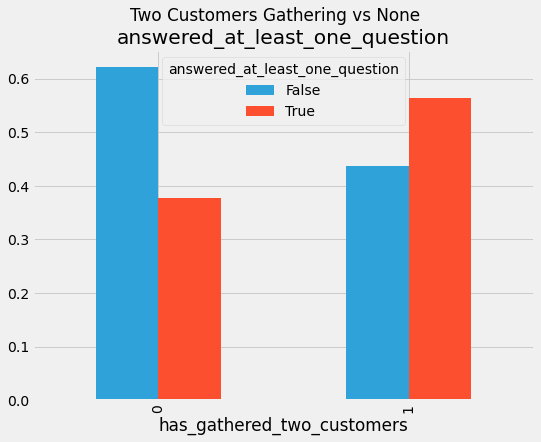

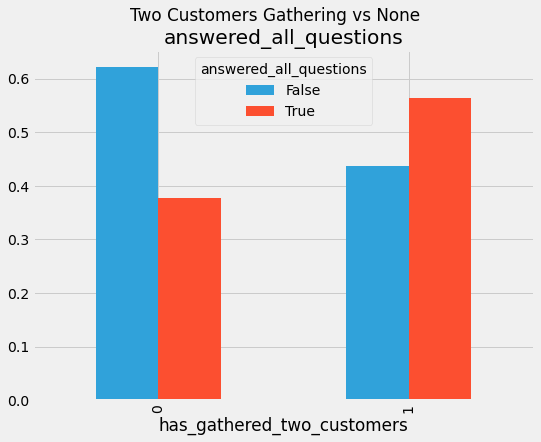

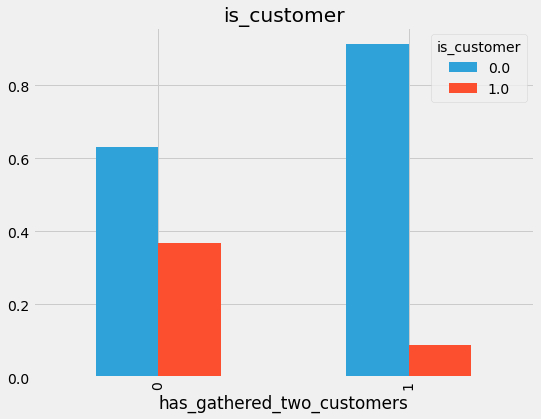

In [148]:
for c in ['app_users','actively_skipped',
       'answered_at_least_one_question', 'answered_all_questions','is_customer']:
    plt.suptitle('Two Customers Gathering vs None')
    f,ax=plt.subplots(figsize=(8,6))
    plt.title(c)
    pd.crosstab(vis_df.has_gathered_two_customers,vis_df[c]).div(pd.crosstab(
        vis_df.has_gathered_two_customers,vis_df[c]).sum(axis=1),axis=0).plot(
        kind='bar',ax=ax)

<Figure size 432x288 with 0 Axes>

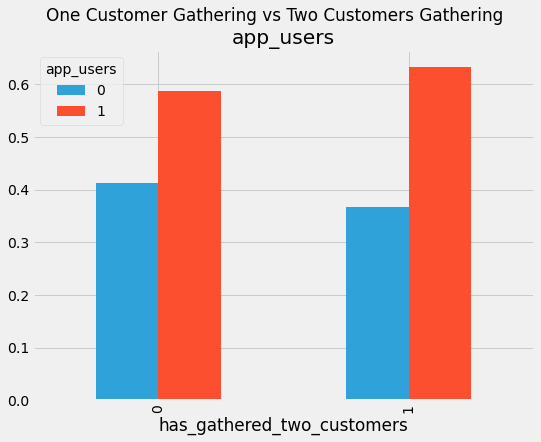

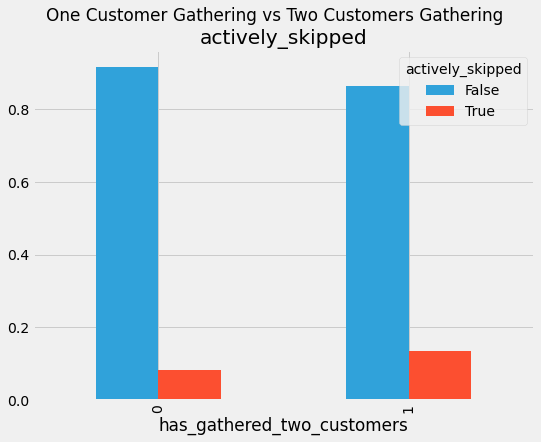

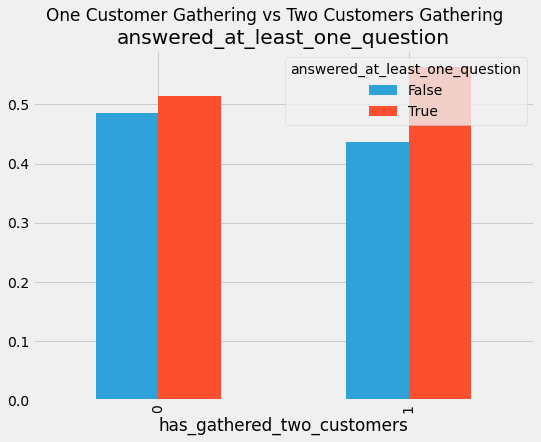

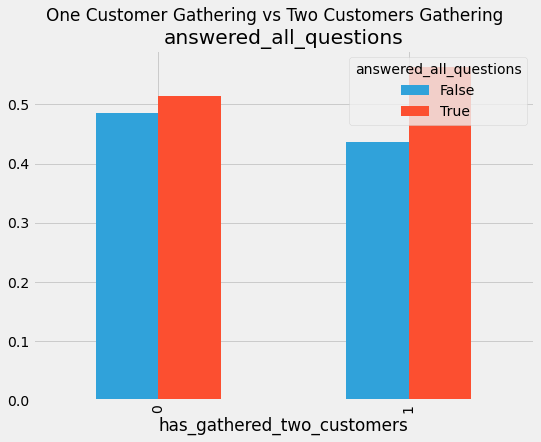

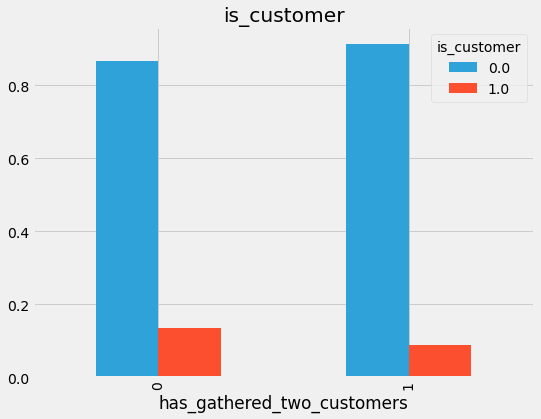

In [150]:
for c in ['app_users','actively_skipped',''
       'answered_at_least_one_question', 'answered_all_questions','is_customer']:
    plt.suptitle('One Customer Gathering vs Two Customers Gathering')
    f,ax=plt.subplots(figsize=(8,6))
    plt.title(c)
    pd.crosstab(df_one_c.has_gathered_two_customers,df_one_c[c]).div(pd.crosstab(df_one_c.has_gathered_two_customers,df_one_c[c]).sum(axis=1),axis=0).plot(kind='bar',ax=ax)

<Figure size 432x288 with 0 Axes>

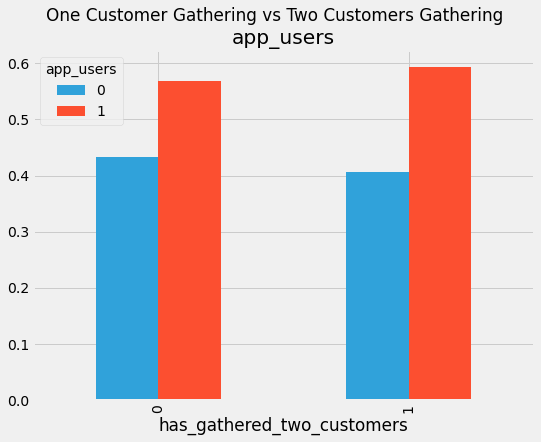

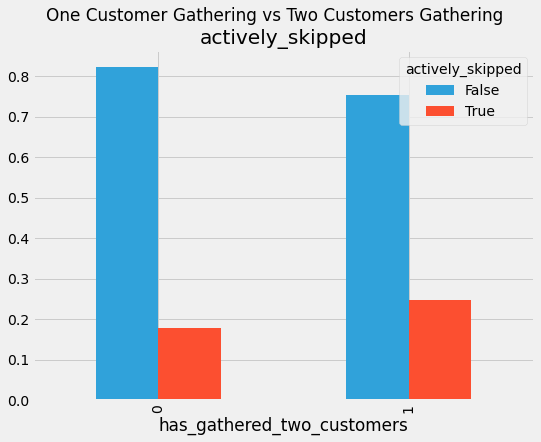

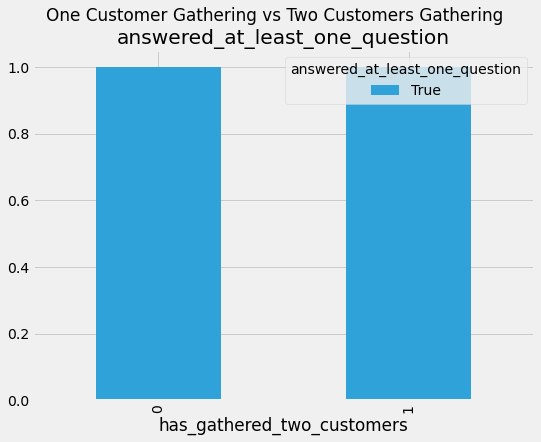

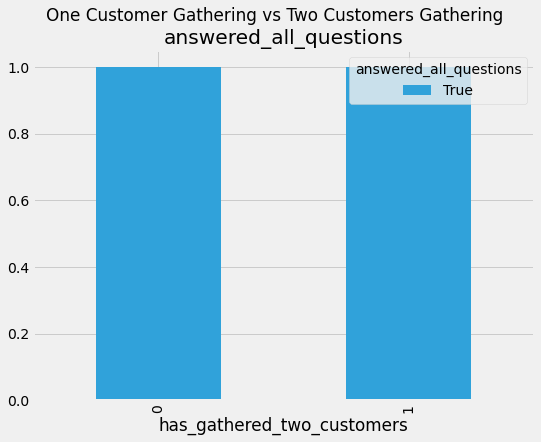

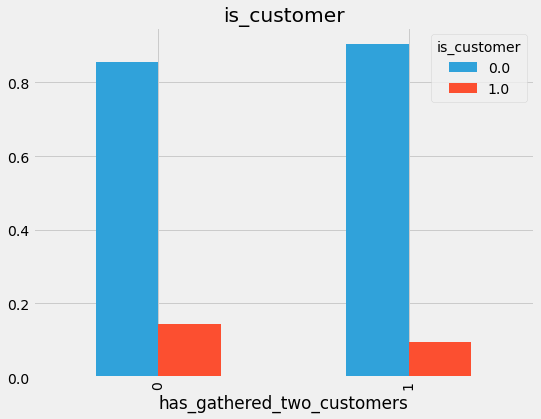

In [77]:
for c in ['app_users','actively_skipped',''
       'answered_at_least_one_question', 'answered_all_questions','is_customer']:
    plt.suptitle('One Customer Gathering vs Two Customers Gathering')
    f,ax=plt.subplots(figsize=(8,6))
    plt.title(c)
    pd.crosstab(df_one_c.has_gathered_two_customers,df_one_c[c]).div(pd.crosstab(df_one_c.has_gathered_two_customers,df_one_c[c]).sum(axis=1),axis=0).plot(kind='bar',ax=ax)

# Summary:
### Model not sufficient enought to be reliable source for prediciton as FP high, resulting in over confidence. Model is intended for better understanding the contributing factors for acquiring two customers
### Partners gathered two customers took less/half the time to achieve each goal along the journey 
### Around 23% (456) gathered one customer out of 1981 live parnters, half of them (241) gathered 2 customers, it took 5 days median to acquire 2nd one,9 days on average 
### 2 customers partners proportionally more app oriented compared to no customers gathering, less likely to be customer themselves (7% are customers out of whole new partner base), much more enaged in profilling questions.  App users much more likely to gather two customers. Behavioural difference between one cutomer and two customers gathering very small

In [65]:
y_proba=model.predict_proba(X_valid[perm_features])[:,1]

In [106]:
valid_result=valid.copy()

In [107]:
valid_result['y_proba']=pd.Series(y_proba)

In [125]:
top10=valid_result.loc[(valid_result.has_gathered_two_customers==1)&(valid_result.app_users==1)].sort_values(by=['y_proba'],ascending=False).head(20)

In [126]:
top10.loc[:,['tenure_verification', 'tenure_getting_started_online_completed',
                          'tenure_first_prospect_added', 'tenure_sixth_prospect_added', 'tenure_1st_appointment']].mean(),top10.loc[:,['tenure_verification', 'tenure_getting_started_online_completed',
                          'tenure_first_prospect_added', 'tenure_sixth_prospect_added', 'tenure_1st_appointment']].median()

(tenure_verification                         0.90
 tenure_getting_started_online_completed     2.35
 tenure_first_prospect_added                 2.10
 tenure_sixth_prospect_added                18.40
 tenure_1st_appointment                     22.35
 dtype: float64,
 tenure_verification                        1.0
 tenure_getting_started_online_completed    1.0
 tenure_first_prospect_added                1.0
 tenure_sixth_prospect_added                4.0
 tenure_1st_appointment                     5.5
 dtype: float64)

In [121]:
top10

,tenure_sixth_prospect_added,tenure_first_prospect_added,tenure_verification,tenure_getting_started_online_completed,app_users,tenure_getting_started_online_completed_from_verification_date,session_number_session_over_120s,total_sessions_last_7d,total_sessions_last_30d,initial_position_type,actively_skipped,answered_at_least_one_question,answered_all_questions,is_customer,days_since_joining_prospect_3,tenure_1st_appointment,has_gathered_two_customers,one_customer_proba,y_proba
169,0.0,0.0,1.0,1.0,1,0.0,0.0,0.0,0.0,0,False,True,True,False,0.0,4.0,1,0.809241,0.967636
193,2.0,2.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0,False,True,True,False,2.0,2.0,1,0.811257,0.962789
443,1.0,0.0,1.0,1.0,1,0.0,1.0,0.0,0.0,0,False,True,True,False,1.0,8.0,1,0.839432,0.959250
412,3.0,2.0,2.0,1.0,1,-1.0,0.0,0.0,0.0,0,False,True,True,False,2.0,2.0,1,0.882254,0.927539
211,7.0,5.0,1.0,5.0,1,4.0,1.0,0.0,12.0,0,True,True,True,False,5.0,5.0,1,0.857132,0.883010


In [166]:
import random
prosps = []
for fp in range(3, 11):
    for sp in range(fp, 16):
        tp = random.choice([*range(sp, 16)] + [91])
        prosps.append([fp, sp, tp])
dicts = []
for isc in [True, False]:
    for ans in [True, False]:
        for gs in range(1, 7):
            for tv in range(1, 16):
                for fsapp in range(1, 16):
                    for ps in prosps:
                        d = {
                            'tenure_verification': tv, #Between 1 and 16 days since joining
                            'tenure_first_prospect_added': ps[0], #Between 1 and 16 days since joining
                            'days_since_joining_prospect_2': ps[1],
                            'days_since_joining_prospect_3': ps[2],
                            'tenure_1st_appointment': fsapp,
                            'tenure_getting_started_online_completed': gs,
                            'tenure_getting_started_online_completed_from_verification_date': gs - tv,
                            'total_sessions_last_30d': random.choice([*range(5, 16)]),
                            'is_customer': isc,
                            'answered_all_questions': ans,
                            'app_users': True
                        }
                        dicts.append(d)
# synthetic_df = pd.DataFrame(dicts).loc[:, perm_features]
#synthetic_df['predictions'] = model.predict_proba(synthetic_df)[:, 1]

In [169]:
synthetic_df=pd.DataFrame(dicts)

In [170]:
synthetic_df

,tenure_verification,tenure_first_prospect_added,days_since_joining_prospect_2,days_since_joining_prospect_3,tenure_1st_appointment,tenure_getting_started_online_completed,tenure_getting_started_online_completed_from_verification_date,total_sessions_last_30d,is_customer,answered_all_questions,app_users
0,1,3,3,4,1,1,0,11,True,True,True
1,1,3,4,4,1,1,0,11,True,True,True
2,1,3,5,7,1,1,0,11,True,True,True
3,1,3,6,6,1,1,0,11,True,True,True
4,1,3,7,14,1,1,0,6,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
410395,15,10,11,91,15,6,-9,13,False,False,True
410396,15,10,12,15,15,6,-9,7,False,False,True
410397,15,10,13,15,15,6,-9,15,False,False,True
410398,15,10,14,14,15,6,-9,7,False,False,True


## LightGBM

In [207]:
len_trn,len_valid=model_length_compute(model_df_copy[col_2_customer],'has_gathered_two_customers',0.25,4)
train,valid=split_df(model_df_copy[col_2_customer],len_trn,len_valid,'has_gathered_two_customers')## length of trainining set,## length for validation set
X_train,y_train,X_valid,y_valid=split_x_y(train,valid,'has_gathered_two_customers')

In [208]:
from copy import copy
from time import time
from typing import Union
from lightgbm import Dataset as lgbDataset
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,roc_auc_score

In [209]:
cat_cols=[]
target='has_gathered_two_customers'
for col in train.columns:
    if train[col].dtype=='O' or train[col].nunique()<15 and col!=target:
        cat_cols.append(col)
num_cols = [c for c in train.columns if c not in cat_cols +[target]]

In [287]:
# for col in cat_cols:
#     le=LabelEncoder()
#     train[col]=le.fit_transform(train[col])
#     le_dict=dict(zip(le.classes_,le.transform(le.classes_)))
#     valid[col]=le.transform(valid[col])

In [210]:
lgbtrain=lgbDataset(
    train[cat_cols+num_cols],train[target],
    categorical_feature=cat_cols,free_raw_data=False)
lgbvalid=lgbDataset(valid[cat_cols+num_cols],
           valid[target],reference=lgbtrain,free_raw_data=False)

In [213]:
import warnings
from typing import Any, Dict, Optional

!pip3 install lightgbm --quiet
!pip3 install hyperopt --quiet
!pip3 install optuna --quiet
import lightgbm as lgb
import pandas as pd
from hyperopt import Trials, fmin, hp, space_eval, tpe
from lightgbm import Dataset as lgbDataset
from optuna.integration.lightgbm import LightGBMTunerCV
from sklearn.metrics import log_loss, mean_squared_error

warnings.filterwarnings("ignore")


class LGBOptimizerHyperopt(object):
    def __init__(
        self,
        objective: str = "binary",
        is_unbalance: bool = False,
        verbose: bool = False,
        num_class: Optional[int] = None,
    ):

        self.objective = objective
        if objective == "multiclass" and not num_class:
            raise ValueError("num_class must be provided for multiclass problems")
        self.num_class = num_class
        self.is_unbalance = is_unbalance
        self.verbose = verbose
        self.early_stop_dict: Dict = {}

    def optimize(
        self,
        dtrain: lgbDataset,
        deval: lgbDataset,
        maxevals: int = 200,
    ):

        if self.objective == "regression":
            self.best = lgb.LGBMRegressor().get_params()
        else:
            self.best = lgb.LGBMClassifier().get_params()
        del (self.best["silent"], self.best["importance_type"])

        param_space = self.hyperparameter_space()
        objective = self.get_objective(dtrain, deval)
        objective.i = 0
        trials = Trials()
        best = fmin(
            fn=objective,
            space=param_space,
            algo=tpe.suggest,
            max_evals=maxevals,
            trials=trials,
            verbose=self.verbose,
        )
        self.trials = trials
        best = space_eval(param_space, trials.argmin)
        best["n_estimators"] = int(best["n_estimators"])
        best["num_leaves"] = int(best["num_leaves"])
        best["min_child_samples"] = int(best["min_child_samples"])
        best["verbose"] = -1
        best["objective"] = self.objective
        self.best.update(best)

    def get_objective(self, dtrain: lgbDataset, deval: lgbDataset):
        def objective(params: Dict[str, Any]) -> float:

            # hyperopt casts as float
            params["n_estimators"] = int(params["n_estimators"])
            params["num_leaves"] = int(params["num_leaves"])
            params["min_child_samples"] = int(params["min_child_samples"])
            params["verbose"] = -1
            params["seed"] = 1

            params["feature_pre_filter"] = False

            params["objective"] = self.objective

            if self.objective != "regression":
                params["is_unbalance"] = self.is_unbalance

            if self.objective == "multiclass":
                params["num_class"] = self.num_class

            model = lgb.train(
                params,
                dtrain,
                valid_sets=[deval],
                early_stopping_rounds=50,
                verbose_eval=False,
            )
            preds = model.predict(deval.data)

            if self.objective != "regression":
                score = log_loss(deval.label, preds)
            elif self.objective == "regression":
                score = mean_squared_error(deval.label, preds)

            objective.i += 1  # type: ignore

            return score

        return objective

    def hyperparameter_space(
        self, param_space: Dict[str, Any] = None
    ) -> Dict[str, Any]:
        space = {
            "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
            "n_estimators": hp.quniform("n_estimators", 100, 1000, 50),
            "num_leaves": hp.quniform("num_leaves", 20, 200, 10),
            "min_child_samples": hp.quniform("min_child_samples", 20, 100, 20),
            "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
            "reg_alpha": hp.choice(
                "reg_alpha", [0.01, 0.05, 0.1, 0.2, 0.4, 1.0, 2.0, 4.0, 10.0]
            ),
            "reg_lambda": hp.choice(
                "reg_lambda", [0.01, 0.05, 0.1, 0.2, 0.4, 1.0, 2.0, 4.0, 10.0]
            ),
        }
        if param_space:
            return param_space
        else:
            return space


class LGBOptimizerOptuna(object):
    def __init__(
        self,
        objective: str = "binary",
        is_unbalance: bool = False,
        verbose: bool = False,
        num_class: Optional[int] = None,
    ):

        self.objective = objective
        if objective == "multiclass" and not num_class:
            raise ValueError("num_class must be provided for multiclass problems")
        self.num_class = num_class
        self.is_unbalance = is_unbalance
        self.verbose = verbose
        self.best: Dict[str, Any] = {}  # Best hyper-parameters

    def optimize(self, dtrain: lgbDataset, deval: lgbDataset):
        # Define the base parameters
        if self.objective == "binary":
            params: Dict = {"objective": self.objective}
        elif self.objective == "multiclass":
            params: Dict = {"objective": self.objective, "metric": "multi_logloss"}
        elif self.objective == "regression":
            params: Dict = {"objective": self.objective, "metric": "rmse"}

        if self.verbose:
            params["verbosity"] = 1
        else:
            params["verbosity"] = -1

        if self.objective != "regression":
            params["is_unbalance"] = self.is_unbalance

        if self.objective == "multiclass":
            params["num_class"] = self.num_class

        # Reformat the data for LightGBM cross validation method
        train_set = lgb.Dataset(
            data=pd.concat([dtrain.data, deval.data]).reset_index(drop=True),
            label=pd.concat([dtrain.label, deval.label]).reset_index(drop=True),
            categorical_feature=dtrain.categorical_feature,
            free_raw_data=False,
        )
        train_index = range(len(dtrain.data))
        valid_index = range(len(dtrain.data), len(train_set.data))

        # Run the hyper-parameter tuning
        self.tuner = LightGBMTunerCV(
            params=params,
            train_set=train_set,
            folds=[(train_index, valid_index)],
            verbose_eval=False,
            num_boost_round=1000,
            early_stopping_rounds=50,
        )

        self.tuner.run()

        self.best = self.tuner.best_params
        # since n_estimators is not among the params that Optuna optimizes we
        # need to add it manually. We add a high value since it will be used
        # with early_stopping_rounds
        self.best["n_estimators"] = 1000  # type: ignore


In [214]:
OPTIMIZE_WITH = "optuna"

In [215]:
if OPTIMIZE_WITH =='optuna':
    optimizer: Union[LGBOptimizerHyperopt, LGBOptimizerOptuna]=LGBOptimizerOptuna()
elif OPTIMIZE_WITH =='hyperopt':
    optimizer = LGBOptimizerHyperopt(verbose=True,objective='binary')

In [216]:
optimizer.optimize(lgbtrain,lgbvalid)

[I 2021-06-29 15:55:07,596] A new study created in memory with name: no-name-3579ae31-2cea-4c46-b941-dd9fcdd8cb92
min_data_in_leaf, val_score: 0.241080: 100%|##########| 5/5 [01:27<00:00, 17.42s/it]


In [292]:
optimizer.best

{'objective': 'binary',
 'verbosity': -1,
 'is_unbalance': False,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 4,
 'feature_fraction': 0.6,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20,
 'n_estimators': 1000}

In [293]:
params=copy(optimizer.best)

In [294]:
params['is_unbalance']=True

In [295]:
start=time()

In [296]:
model=lgb.train(params,lgbtrain,valid_sets=[lgbvalid],
          early_stopping_rounds=50,verbose_eval=True)
runtime=time()-start

[1]	valid_0's binary_logloss: 0.487843
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.474538
[3]	valid_0's binary_logloss: 0.464669
[4]	valid_0's binary_logloss: 0.458778
[5]	valid_0's binary_logloss: 0.457793
[6]	valid_0's binary_logloss: 0.456105
[7]	valid_0's binary_logloss: 0.456541
[8]	valid_0's binary_logloss: 0.456602
[9]	valid_0's binary_logloss: 0.455054
[10]	valid_0's binary_logloss: 0.455762
[11]	valid_0's binary_logloss: 0.4561
[12]	valid_0's binary_logloss: 0.458593
[13]	valid_0's binary_logloss: 0.461074
[14]	valid_0's binary_logloss: 0.462848
[15]	valid_0's binary_logloss: 0.463956
[16]	valid_0's binary_logloss: 0.465588
[17]	valid_0's binary_logloss: 0.466876
[18]	valid_0's binary_logloss: 0.47016
[19]	valid_0's binary_logloss: 0.471406
[20]	valid_0's binary_logloss: 0.47172
[21]	valid_0's binary_logloss: 0.472649
[22]	valid_0's binary_logloss: 0.473442
[23]	valid_0's binary_logloss: 0.474515
[24]	valid_0's binary_logloss: 0

In [297]:
preds=(model.predict(lgbvalid.data)>0.5).astype('int')

In [298]:
acc=accuracy_score(lgbvalid.label,preds)
auc=roc_auc_score(lgbvalid.label,preds)
f1=f1_score(lgbvalid.label,preds)

Accuracy: 0.8132780082987552. F1: 0.5. ROC_AUC: 0.6802753382387847
Recall: 0.45454545454545453
Precision: 0.5555555555555556
[[347  36]
 [ 54  45]]


Text(13.060000000000002, 0.5, 'True label')

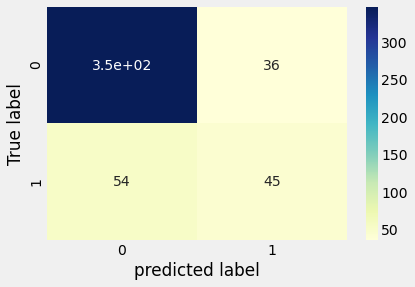

In [299]:
tn,fp,fn,tp=confusion_matrix(lgbvalid.label,preds).ravel()
recall = tp/(tp+fn)
precision = tp/(tp+fp)
print(f'Accuracy: {acc}. F1: {f1}. ROC_AUC: {auc}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(confusion_matrix(lgbvalid.label,preds))
cm=confusion_matrix(lgbvalid.label,preds)

sns.heatmap(cm,annot=True,cmap="YlGnBu")
plt.xlabel('predicted label')
plt.ylabel('True label')

In [231]:
def check_lgb_parameters(parameters,values,fixed={},features=None):
    scores=[]
    f1=[]
    auc=[]
    for p in values:
        print(f'Fitting with {parameters}={p}')
        fts= lgbtrain.data.columns if features is None else features
        kw = {parameters:p, **fixed}
        model=lgb.LGBMClassifier(**kw)
        model.fit(lgbtrain.data[fts],lgbtrain.label)
        s=roc_auc_score(lgbvalid.label,model.predict_proba(lgbvalid.data)[:,1])
        rf_f1,rf_auc=auc_score(model,lgbvalid.data[fts],lgbvalid.label)
        
        print('ROC AUC Score',s)
        print('F1',rf_f1)
        print('Auc',rf_auc)
        print('')
        scores.append(rf_auc)
        f1.append(rf_f1)
        auc.append(rf_auc)
    plt.title(parameters)
    plt.plot(values,scores)

Fitting with learning_rate=0.01
ROC AUC Score 0.8107793622499504
F1 0.3211678832116788
Auc 0.5444328782529536

Fitting with learning_rate=0.3
ROC AUC Score 0.6888987918399684
F1 0.44329896907216493
Auc 0.4850430375005009



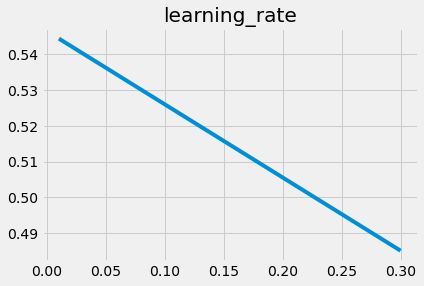

In [233]:
check_lgb_parameters(p,v)

Fitting with n_estimators=10
ROC AUC Score 0.7981654783125371
F1 0.0
Auc 0.5090516779036963

Fitting with n_estimators=30
ROC AUC Score 0.8024485046543869
F1 0.0
Auc 0.5309360219146206

Fitting with n_estimators=50
ROC AUC Score 0.804998514557338
F1 0.0
Auc 0.5320681263625244

Fitting with n_estimators=100
ROC AUC Score 0.8107793622499504
F1 0.3211678832116788
Auc 0.5444328782529536

Fitting with n_estimators=200
ROC AUC Score 0.804948999801941
F1 0.45283018867924524
Auc 0.5573801461294104

Fitting with n_estimators=300
ROC AUC Score 0.7987720340661517
F1 0.4615384615384615
Auc 0.5463507471303988



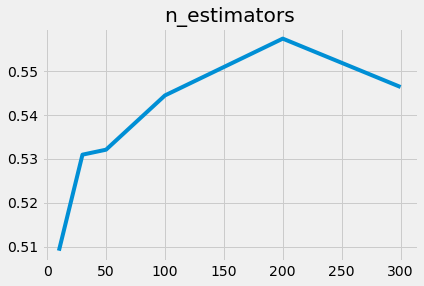

In [236]:
f={'learning_rate':0.01}
p='n_estimators'
v=[10,30,50,100,200,300]
check_lgb_parameters(p,v,f)

Fitting with num_leaves=10
ROC AUC Score 0.8091082392552981
F1 0.4578313253012048
Auc 0.5476431146090984

Fitting with num_leaves=20
ROC AUC Score 0.8037977817389583
F1 0.46625766871165647
Auc 0.5439324643071901

Fitting with num_leaves=50
ROC AUC Score 0.8043424440483264
F1 0.45283018867924524
Auc 0.5557754085194301

Fitting with num_leaves=100
ROC AUC Score 0.8043424440483264
F1 0.45283018867924524
Auc 0.5557754085194301



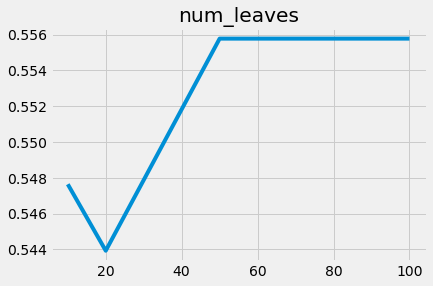

In [237]:
f={'learning_rate':0.01,
  'n_estimators':200}
p='num_leaves'
v=[10,20,50,100]
check_lgb_parameters(p,v,f)

Fitting with min_child_samples=10
ROC AUC Score 0.7730367399485047
F1 0.39751552795031053
Auc 0.505391380424229

Fitting with min_child_samples=20
ROC AUC Score 0.8043424440483264
F1 0.45283018867924524
Auc 0.5557754085194301

Fitting with min_child_samples=30
ROC AUC Score 0.8094548425430779
F1 0.47204968944099374
Auc 0.5758549836926047

Fitting with min_child_samples=50
ROC AUC Score 0.8121905327787681
F1 0.47500000000000003
Auc 0.597226429942811

Fitting with min_child_samples=100
ROC AUC Score 0.8144805902158844
F1 0.4578313253012048
Auc 0.5839939173592095



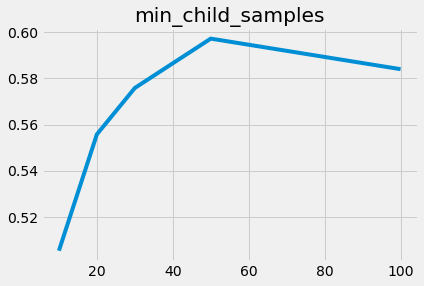

In [240]:
f={'learning_rate':0.01,
  'n_estimators':200,
  'num_leaves':50}
p='min_child_samples'
v=[10,20,30,50,100]
check_lgb_parameters(p,v,f)

Fitting with colsample_bytree=0.5
ROC AUC Score 0.8246311150722915
F1 0.46249999999999997
Auc 0.6124129306184783

Fitting with colsample_bytree=1.0
ROC AUC Score 0.8121905327787681
F1 0.47500000000000003
Auc 0.597226429942811



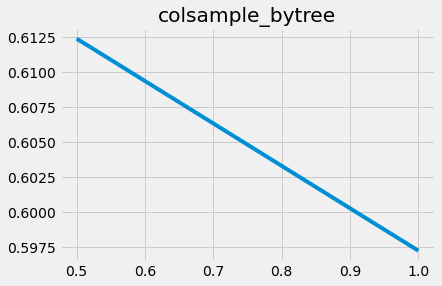

In [241]:
f={'learning_rate':0.01,
  'n_estimators':200,
  'num_leaves':50,
  'min_child_samples':50}
p='colsample_bytree'
v=[0.5, 1.0]
check_lgb_parameters(p,v,f)

Fitting with reg_alpha=0.01
ROC AUC Score 0.823715092097445
F1 0.46249999999999997
Auc 0.6085724343836147

Fitting with reg_alpha=0.05
ROC AUC Score 0.8238636363636362
F1 0.46249999999999997
Auc 0.612293791262041

Fitting with reg_alpha=0.1
ROC AUC Score 0.8226257674787085
F1 0.46249999999999997
Auc 0.6106740009238906

Fitting with reg_alpha=0.2
ROC AUC Score 0.8226505248564072
F1 0.46249999999999997
Auc 0.6136264862246186

Fitting with reg_alpha=0.4
ROC AUC Score 0.820409982174688
F1 0.4556962025316456
Auc 0.6144118453510514

Fitting with reg_alpha=1.0
ROC AUC Score 0.8198158051099227
F1 0.4430379746835442
Auc 0.6113084770502017

Fitting with reg_alpha=2.0
ROC AUC Score 0.820806100217865
F1 0.45859872611464964
Auc 0.6087057845009681



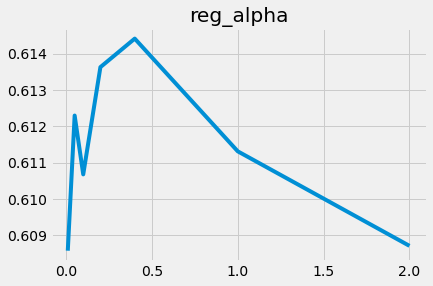

In [243]:
f={'learning_rate':0.01,
  'n_estimators':200,
  'num_leaves':50,
  'min_child_samples':50,
  'colsample_bytree':0.5}
p='reg_alpha'
v=[0.01, 0.05, 0.1, 0.2, 0.4, 1.0, 2.0]
check_lgb_parameters(p,v,f)

Fitting with reg_lambda=0.01
ROC AUC Score 0.8228485838779956
F1 0.46249999999999997
Auc 0.6136743025028566

Fitting with reg_lambda=0.05
ROC AUC Score 0.8211155674390967
F1 0.46249999999999997
Auc 0.6132561552130436

Fitting with reg_lambda=0.1
ROC AUC Score 0.8204471182412358
F1 0.4556962025316456
Auc 0.6151168028210755

Fitting with reg_lambda=0.2
ROC AUC Score 0.8210908100613983
F1 0.4556962025316456
Auc 0.6170753646070349

Fitting with reg_lambda=0.4
ROC AUC Score 0.8197415329768271
F1 0.4556962025316456
Auc 0.6142466107720632

Fitting with reg_lambda=1.0
ROC AUC Score 0.8198158051099227
F1 0.445859872611465
Auc 0.6127082541330753

Fitting with reg_lambda=2.0
ROC AUC Score 0.8197539116656763
F1 0.4487179487179487
Auc 0.6076995234303983



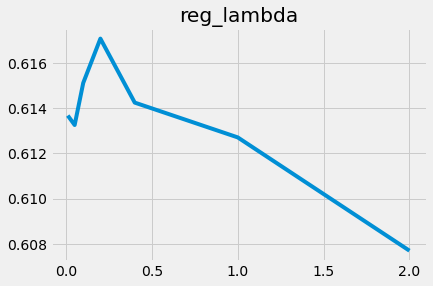

In [244]:
f={'learning_rate':0.01,
  'n_estimators':200,
  'num_leaves':50,
  'min_child_samples':50,
  'colsample_bytree':0.5,
  'reg_alpha':0.2}
p='reg_lambda'
v=[0.01, 0.05, 0.1, 0.2, 0.4, 1.0, 2.0]
check_lgb_parameters(p,v,f)

Fitting with boosting_type=gbdt
ROC AUC Score 0.8356406519861831
F1 0.43356643356643354
Auc 0.5790900120363615

Fitting with boosting_type=dart
ROC AUC Score 0.8325102547495682
F1 0.43283582089552236
Auc 0.5934289075122707

Fitting with boosting_type=goss
ROC AUC Score 0.8323078583765112
F1 0.45517241379310336
Auc 0.5789625817050246



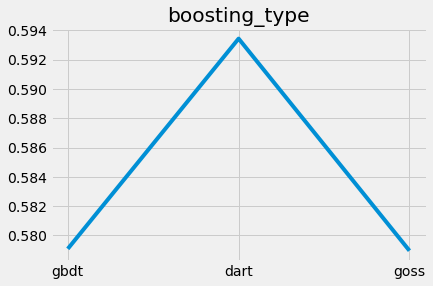

In [260]:
f={'learning_rate':0.01,
  'n_estimators':200,
  'num_leaves':50,
  'min_child_samples':50,
  'colsample_bytree':0.5,
  'reg_alpha':0.2,
  'reg_lambda':0.2}
p='boosting_type'
v=['gbdt','dart','goss']
check_lgb_parameters(p,v,f)

Fitting with max_depth=2
ROC AUC Score 0.8271669905008636
F1 0.39999999999999997
Auc 0.5744114424848239

Fitting with max_depth=3
ROC AUC Score 0.8300680051813472
F1 0.42424242424242425
Auc 0.5811676071043023

Fitting with max_depth=5
ROC AUC Score 0.8323618307426598
F1 0.43283582089552236
Auc 0.5932161650333208

Fitting with max_depth=10
ROC AUC Score 0.8325102547495682
F1 0.43283582089552236
Auc 0.5934289075122707



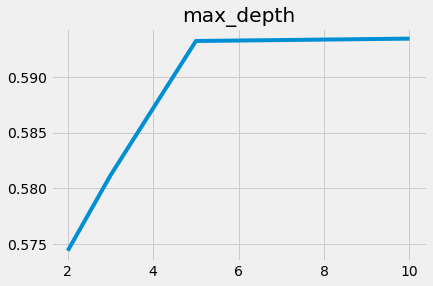

In [261]:
f={'learning_rate':0.01,
  'n_estimators':200,
  'num_leaves':50,
  'min_child_samples':50,
  'colsample_bytree':0.5,
  'reg_alpha':0.2,
  'reg_lambda':0.2,
  'boosting_type':'dart'}
p='max_depth'
v=[2,3,5,10]
check_lgb_parameters(p,v,f)

In [269]:
f={'learning_rate':0.01,
  'n_estimators':200,
  'num_leaves':50,
  'min_child_samples':50,
  'colsample_bytree':0.5,
  'reg_alpha':0.2,
  'reg_lambda':0.2,
  'boosting_type':'gbdt',
  'max_depth':5,
  'objective':'binary',
  'random_state':482}

In [270]:
model=lgb.LGBMClassifier(**f)
%time model.fit(lgbtrain.data,lgbtrain.label)

CPU times: user 13.7 s, sys: 210 ms, total: 13.9 s
Wall time: 2.99 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=50, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=50, objective='binary',
               random_state=482, reg_alpha=0.2, reg_lambda=0.2, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


    Training ROC_AUC :0.856170542635659
    Training F1 : 0.5047318611987381
    Training AUC: 0.6929473472310486

    Validation ROC_AUC: 0.82628993955095
    Validation F1: 0.43971631205673756
    Validation AUC: 0.5782971490183102

    
True Negatives: 372
False Positives: 14
False Negatives 65
True Positives: 31
Recall: 0.3229166666666667
Precision: 0.6888888888888889


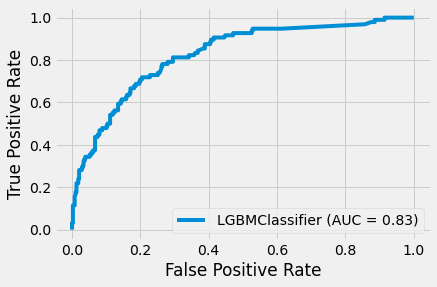

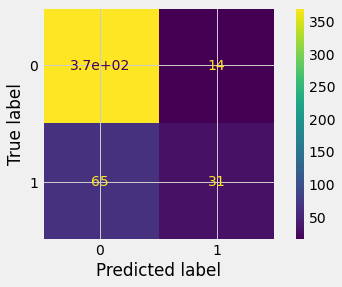

In [272]:
print_lgb_report(model,lgbtrain,lgbvalid)

In [319]:
# SAVE RESULTS

from datetime import datetime
suffix=str(datetime.now()).replace(' ','_').split('_')[:-1][0]
results_filename='_'.join(['new_partners_prection_one_customer',suffix])
model_filename='_'.join(['model_new_partners_prection_one_customer',suffix])

In [328]:
with open(os.path.join(os.getcwd(),results_filename),'wb') as f:
    pickle.dump(results_d,f)
with open(os.path.join(os.getcwd(),model_filename),'wb') as f:
    pickle.dump(model,f)

<_io.BufferedWriter name='/home/jovyan/persisted/RFM/new_partners_prection_one_customer_2021-06-23'>
